# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extract Audio Dataset

In [2]:
!unzip '/content/drive/MyDrive/MS_in_AAI/Courses_and_Projects/AAI-510-IN2_Machine learning - Fundamentals and Applications/AAI-510-IN2_Final Project/AAI-510-IN2_Dataset/RAVDESS_Emotional_Speech_Audio_Dataset.zip' -d '/content/extracted_speech_audio_dataset'

Archive:  /content/drive/MyDrive/MS_in_AAI/Courses_and_Projects/AAI-510-IN2_Machine learning - Fundamentals and Applications/AAI-510-IN2_Final Project/AAI-510-IN2_Dataset/RAVDESS_Emotional_Speech_Audio_Dataset.zip
  inflating: /content/extracted_speech_audio_dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/extracted_speech_audio_dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/extracted_speech_audio_dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/extracted_speech_audio_dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/extracted_speech_audio_dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/extracted_speech_audio_dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/extracted_speech_audio_dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/extracted_speech_audio_dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/extracted_speech_audio_dataset/Actor_01/03-01-02-02-

# Install and Import all the libraries

In [3]:
!pip install pyloudnorm

In [4]:
!pip install xgboost

In [102]:
import os
import gc
import math
import itertools
import json
import time
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import pyloudnorm as pyln
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from joblib import delayed, Parallel

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchaudio
import torchaudio.transforms as T

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Activation, BatchNormalization

# EDA and Audio Data Preprocessing

In [6]:
# Base directory where files are extracted
base_dir = "/content/extracted_speech_audio_dataset"

In [7]:
file_emotion = []
file_path = []

# Helper function to process all .wav files in a given directory tree
def capture_audio_file_paths(file_base_path):
    for root, dirs, files in os.walk(file_base_path):
        for file in files:
            if file.endswith('.wav'):
                parts = file.split('.')[0].split('-')
                if len(parts) >= 3:
                    try:
                        emotion_code = int(parts[2])
                        file_emotion.append(emotion_code)
                        file_path.append(os.path.join(root, file))
                    except ValueError:
                        continue  # skip non-standard filenames

In [8]:
# Parse both locations
capture_audio_file_paths(os.path.join(base_dir, "audio_speech_actors_01-24"))
capture_audio_file_paths(base_dir)  # this includes Actor_01 to Actor_24 directly under /content/extracted_speech_audio_dataset

# Create a dataframe
emotion = pd.DataFrame(file_emotion, columns=['Emotions'])
path = pd.DataFrame(file_path, columns=['Path'])
data = pd.concat([emotion, path], axis=1)

# Emotion label mapping
emotion_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}

data['Emotions'] = data['Emotions'].map(emotion_map)

In [9]:
# Save to CSV
emotion_data = "/content/EmotionData"
os.makedirs(emotion_data, exist_ok=True)
data.to_csv(os.path.join(emotion_data, "emotion_audio_dataset.csv"), index=False)

In [10]:
# View the CSV
data.head(25)

Emotions                                               Path
0       calm  /content/extracted_speech_audio_dataset/audio_...
1      angry  /content/extracted_speech_audio_dataset/audio_...
2       calm  /content/extracted_speech_audio_dataset/audio_...
3        sad  /content/extracted_speech_audio_dataset/audio_...
4       calm  /content/extracted_speech_audio_dataset/audio_...
5      angry  /content/extracted_speech_audio_dataset/audio_...
6      happy  /content/extracted_speech_audio_dataset/audio_...
7      happy  /content/extracted_speech_audio_dataset/audio_...
8    disgust  /content/extracted_speech_audio_dataset/audio_...
9    disgust  /content/extracted_speech_audio_dataset/audio_...
10  surprise  /content/extracted_speech_audio_dataset/audio_...
11      fear  /content/extracted_speech_audio_dataset/audio_...
12      calm  /content/extracted_speech_audio_dataset/audio_...
13       sad  /content/extracted_speech_audio_dataset/audio_...
14       sad  /content/extracted_speech_audio_dataset/audio_...
15     angry  /content/extracted_speech_audio_dataset/audio_...
16       sad  /content/extracted_speech_audio_dataset/audio_...
17     angry  /content/extracted_speech_audio_dataset/audio_...
18     happy  /content/extracted_speech_audio_dataset/audio_...
19     angry  /content/extracted_speech_audio_dataset/audio_...
20      fear  /content/extracted_speech_audio_dataset/audio_...
21      fear  /content/extracted_speech_audio_dataset/audio_...
22       sad  /content/extracted_speech_audio_dataset/audio_...
23       sad  /content/extracted_speech_audio_dataset/audio_...
24   neutral  /content/extracted_speech_audio_dataset/audio_...

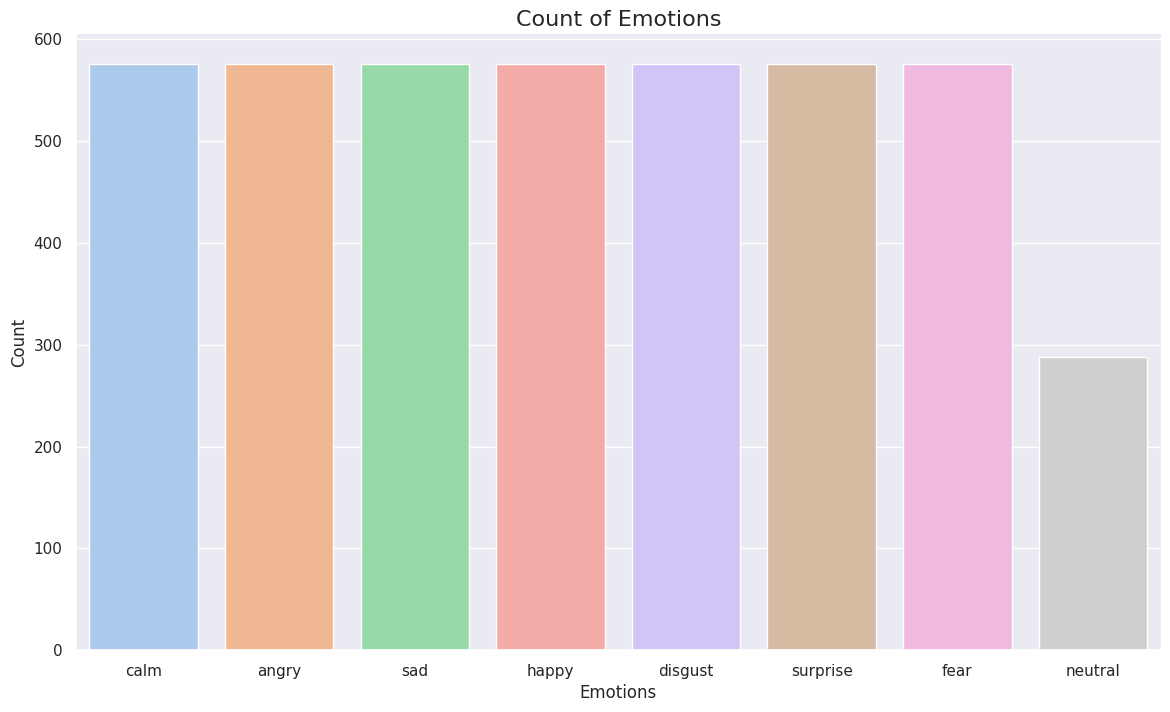

In [11]:
# Set the Seaborn theme
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='mako',
    font='sans-serif',
    font_scale=1,
    color_codes=True
)

# Create a figure
plt.figure(figsize=(14, 8))

# Plot the count of each emotion
sns.countplot(
    x='Emotions',
    data=data,
    order=data['Emotions'].value_counts().index,
    palette='pastel'
)

# Set plot labels and title
plt.title('Count of Emotions', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Emotions', fontsize=12)

# Remove top and right spines
sns.despine(top=True, right=True)

# Save the plot to the same EmotionData directory
plt.savefig(os.path.join(emotion_data, "emotions_plot.png"))

# Show the plot
plt.show()

In [12]:
def create_and_save_spectrogram(file_path, emotion_label, save_root):
    try:
        y, sr = librosa.load(file_path, duration=5.0)
        X = librosa.stft(y)
        Xdb = librosa.amplitude_to_db(abs(X))

        emotion_dir = os.path.join(save_root, emotion_label)
        os.makedirs(emotion_dir, exist_ok=True)

        base_name = os.path.basename(file_path).replace('.wav', '.png')
        save_path = os.path.join(emotion_dir, base_name)

        plt.figure(figsize=(10, 3))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"{emotion_label}", fontsize=10)
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

    except Exception as e:
        print(f"Failed creating spectogram for {file_path}: {e}")

In [13]:
def process_in_batches(data, batch_size=100):
    total = len(data)
    for start in range(0, total, batch_size):
        end = min(start + batch_size, total)
        batch = data.iloc[start:end]
        print(f"Processing batch: {start}-{end}")
        for idx, row in tqdm(batch.iterrows(), total=len(batch), desc=f"Batch {start//batch_size + 1}"):
            create_and_save_spectrogram(row['Path'], row['Emotions'], spectrogram_root)
        gc.collect()

In [ ]:
# Directory to save spectrograms
spectrogram_root = os.path.join(emotion_data, "spectrograms")

# Call the function to process
process_in_batches(data, batch_size=100)

Processing batch: 0-100


Batch 1: 100%|██████████| 100/100 [01:03<00:00,  1.59it/s]


Processing batch: 100-200


Batch 2: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Processing batch: 200-300


Batch 3: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Processing batch: 300-400


Batch 4: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Processing batch: 400-500


Batch 5: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Processing batch: 500-600


Batch 6: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Processing batch: 600-700


Batch 7: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Processing batch: 700-800


Batch 8: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Processing batch: 800-900


Batch 9: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Processing batch: 900-1000


Batch 10: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Processing batch: 1000-1100


Batch 11:  63%|██████▎   | 63/100 [00:46<02:23,  3.89s/it]

In [14]:
# Take a random sample (e.g., 250 files)
sample_audio_data = data.sample(n=1500, random_state=42).copy()

# Initialize lists
audio_durations = []
audio_pitches = []
audio_energies = []
audio_zcr = []

for path in sample_audio_data['Path']:
    y, sr = librosa.load(path, sr=None)
    pitches_, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = pitches_[magnitudes > np.median(magnitudes)].mean()
    energy = np.mean(y**2)
    duration = librosa.get_duration(y=y, sr=sr)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))

    audio_pitches.append(pitch)
    audio_energies.append(energy)
    audio_durations.append(duration)
    audio_zcr.append(zcr)


# Add columns to DataFrame
sample_audio_data['Duration'] = audio_durations
sample_audio_data['Pitch'] = audio_pitches
sample_audio_data['Energy'] = audio_energies
sample_audio_data['ZCR'] = audio_zcr

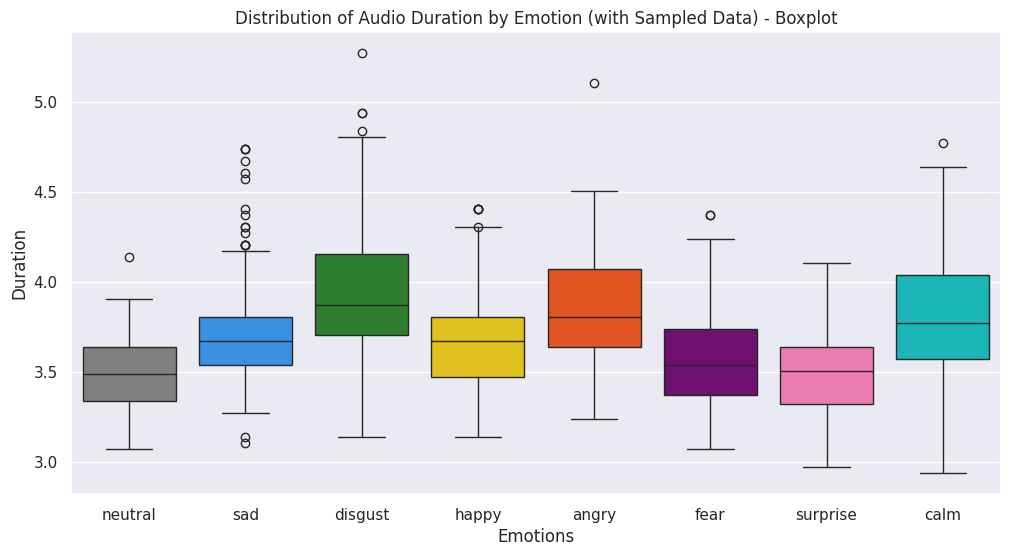

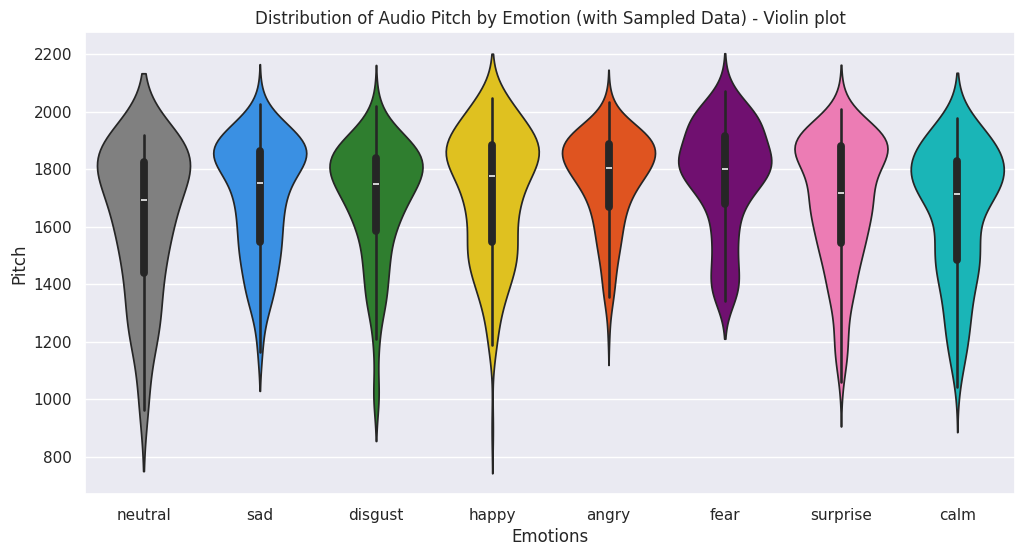

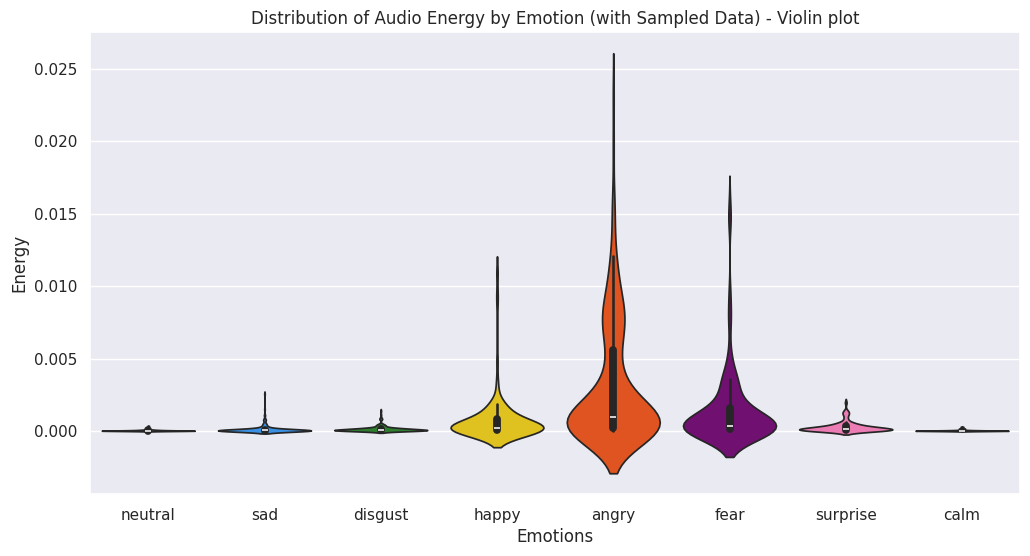

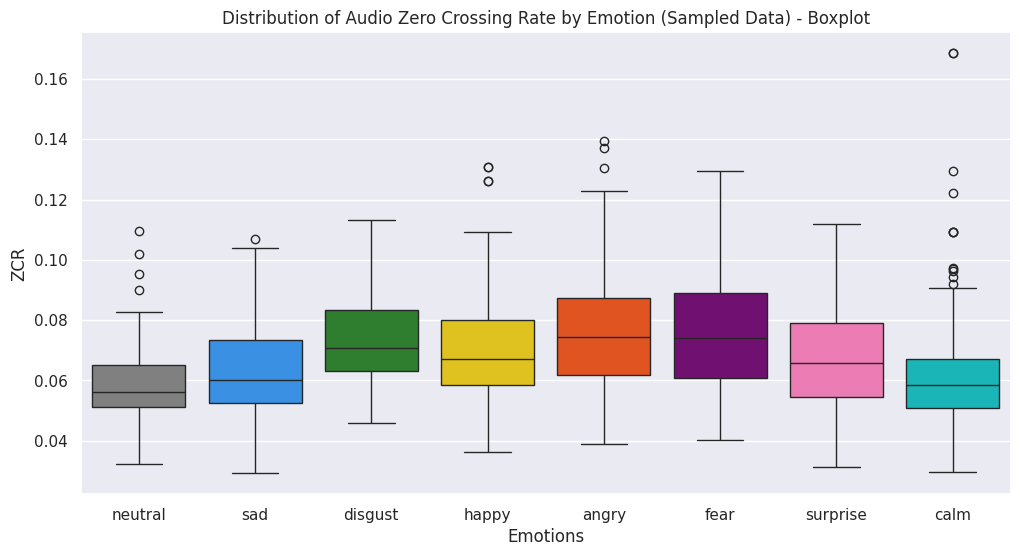

In [15]:
custom_palette = {
    "happy": "#FFD700",    # gold
    "sad": "#1E90FF",      # dodger blue
    "angry": "#FF4500",    # orange red
    "neutral": "#808080",  # gray
    "calm": "#00CED1",     # dark turquoise
    "fear": "#800080",     # purple
    "disgust": "#228B22",  # forest green
    "surprise": "#FF69B4"  # hot pink
}

# Duration - Boxplot with custom colors
plt.figure(figsize=(12, 6))
sns.boxplot(x='Emotions', y='Duration', data=sample_audio_data, palette=custom_palette)
plt.title("Distribution of Audio Duration by Emotion (with Sampled Data) - Boxplot")
plt.show()
print("\n\n")

# Pitch - Violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Emotions', y='Pitch', data=sample_audio_data, palette=custom_palette)
plt.title("Distribution of Audio Pitch by Emotion (with Sampled Data) - Violin plot")
plt.show()
print("\n\n")

# Energy - Violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Emotions', y='Energy', data=sample_audio_data, palette=custom_palette)
plt.title("Distribution of Audio Energy by Emotion (with Sampled Data) - Violin plot")
plt.show()

# ZCR - Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Emotions', y='ZCR', data=sample_audio_data, palette=custom_palette)
plt.title("Distribution of Audio Zero Crossing Rate by Emotion (Sampled Data) - Boxplot")
plt.show()

In [16]:
# Ensure each emotion is a string (fix nested arrays or wrong types)
def clean_emotion(value):
    # If it's a numpy array or list like ['happy'], take the first element
    if isinstance(value, (np.ndarray, list)):
        return str(value[0])
    return str(value)

In [17]:
# Apply the cleaning function
sample_audio_data['Emotions'] = sample_audio_data['Emotions'].apply(clean_emotion)

In [18]:
sample_audio_data['Emotions'].apply(type).unique()

array([<class 'str'>], dtype=object)

In [19]:
sample_audio_data['Emotions'].unique()

array(['neutral', 'sad', 'disgust', 'happy', 'angry', 'fear', 'surprise',
       'calm'], dtype=object)

In [20]:
# Extract MFCCs (e.g., 13 coefficients) and average over time axis
def extract_mfcc(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_mean = np.mean(mfccs, axis=1)  # Take mean over time
        return mfccs_mean
    except Exception as e:
        print(f"Error extracting MFCCs from {file_path}: {e}")
        return np.zeros(n_mfcc)

In [21]:
# Extract MFCCs for all files and stack them
mfcc_features = []

for path in sample_audio_data['Path']:
    mfcc = extract_mfcc(path)
    mfcc_features.append(mfcc)

# Convert to DataFrame with reset index to align with sample_audio_data
mfcc_df = pd.DataFrame(mfcc_features, columns=[f'MFCC_{i+1}' for i in range(13)])
mfcc_df.reset_index(drop=True, inplace=True)
sample_audio_data.reset_index(drop=True, inplace=True)

In [22]:
# Concatenate all indices are aligned (0–249)
features = pd.concat([
    mfcc_df,
    sample_audio_data[['Pitch', 'Energy', 'ZCR', 'Duration', 'Emotions']]
], axis=1)

In [23]:
features.head(50)

MFCC_1     MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0  -712.075562  76.019432  12.366280  21.779139   8.561011  15.253534   
1  -787.723511  86.244698   9.011122  18.975998  10.758525  14.432211   
2  -604.800964  67.389900 -13.988151   8.438960  -4.720516  -2.079224   
3  -632.525146  85.255318   0.547400   7.576108   9.906102  17.834745   
4  -563.286560  49.648838  -6.105738  10.458235  -5.491735  -0.331518   
5  -686.033997  72.008377  -1.778627   8.038586  -2.396514  13.993361   
6  -748.791626  68.438736   0.857495  16.576460  -3.619491   6.739974   
7  -546.403809  72.933098 -12.618839  -1.159809  -7.349758   0.183595   
8  -672.124634  95.870300   0.999782   9.010865   9.643557  12.556573   
9  -760.203796  82.786682 -12.983112  13.909020   4.607139  11.596461   
10 -470.355530  48.446110 -21.689026   3.126088 -10.172422   2.192826   
11 -599.161316  56.842281 -22.899433  -1.210327  -5.610211  -1.711219   
12 -368.059174  39.131107 -46.643871 -17.280827 -22.566322  -0.989352   
13 -595.817078  59.382217 -25.655392   1.516192  -4.867662  -1.965269   
14 -560.186462  44.504402 -14.639299   2.251492 -11.031190   5.346807   
15 -589.548340  58.119892  -3.603061   9.387148  -3.215238   5.062185   
16 -394.309662  58.839634 -19.951685   3.469005   3.198620   8.317451   
17 -693.705688  67.951782  -0.387808  13.617414   0.732300  11.593903   
18 -519.525391  62.828537  -5.587942   9.451094   5.105152  15.728414   
19 -530.760559  51.744469  -2.148309  18.807043   2.547280  11.871601   
20 -519.525391  62.828537  -5.587942   9.451094   5.105152  15.728414   
21 -646.045776  62.353695   2.875447  12.085875   4.534707  12.167144   
22 -485.261902  70.141365  -8.326092   5.963150   1.400769  15.818752   
23 -689.394043  70.910362   1.613997  13.872520   3.828407  11.299436   
24 -676.850769  66.879372 -13.539673   3.807712  -0.418603  -0.734826   
25 -703.635925  57.355385 -14.369708   5.223923  -2.721664  -0.359018   
26 -629.670532  58.680077 -10.326650   1.892728  -8.061831   5.900236   
27 -659.756287  54.014687  -1.545817   7.952788   2.421426  11.948643   
28 -590.847839  63.929508  -0.203056  12.907093   5.051848  15.743986   
29 -609.373840  63.767937  -9.062080   7.472404  -2.382280  11.419916   
30 -706.430054  95.198959   4.849506  12.325830  11.469189  20.628059   
31 -482.470520  49.874416 -15.788864   2.726302   0.071360   1.572713   
32 -621.832336  82.457634  -4.856926   8.793169   9.400360  21.183865   
33 -595.685974  72.476997  -3.595546  10.491075  -4.531944   7.739019   
34 -410.085022  53.680950 -17.276892   0.900245  -3.710184   5.732750   
35 -698.403137  90.158752   2.951090  14.607257  12.337191  16.082130   
36 -714.532776  77.487587   5.394833   9.028925   5.506475  16.064686   
37 -482.470520  49.874416 -15.788864   2.726302   0.071360   1.572713   
38 -679.538757  78.698463   0.667738  10.390019   5.207020  11.525229   
39 -481.288788  26.917099 -27.858831  -5.018194 -16.005667  -2.853803   
40 -699.590149  72.308266   5.620214  19.475849   4.636010   7.867966   
41 -599.909424  64.423981  -6.375223  10.306619  -6.254834   2.284633   
42 -735.616394  74.105850   5.410368  17.390242   6.555936  12.561914   
43 -771.897095  89.865509   9.974906  20.977039   9.715435  10.355268   
44 -586.493591  50.823910 -20.859858   3.563087  -6.354978  -1.503147   
45 -605.542480  71.944672  -1.672075  12.170443   5.372849  16.081848   
46 -714.440063  46.369209   3.132820  13.724387  -1.775289   4.937009   
47 -549.740234  55.989716 -12.765321  10.724632 -10.467362   2.329084   
48 -698.853394  63.960659  -0.885864  11.611211   0.270961   7.479338   
49 -742.292603  63.671303  -1.489987  17.553986   0.073392   8.155811   

       MFCC_7     MFCC_8     MFCC_9    MFCC_10    MFCC_11    MFCC_12  \
0   -6.755793  12.945807  -7.801950  -2.183830  -0.115249  -2.756708   
1   -1.926521   5.288622  -1.091180  -3.500432   2.367798   4.008994   
2   -7.776217   2.852065 -10.106051  -6.681345  -3.561178   0.107069

In [24]:
features.tail(50)

MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
1450 -619.324402   75.793678 -11.967565   6.118998   0.272492   8.626915   
1451 -492.108582   42.304478 -34.118587  -6.350569  -8.457234   0.389790   
1452 -622.560669   77.298363   2.511310  22.080553  -0.385559   9.037427   
1453 -454.506439   32.319195 -18.824198  -0.799793 -14.787984  -2.805204   
1454 -688.776001   60.152584  -4.903641   7.696042  -3.110375   1.767932   
1455 -693.651123   71.460747  -1.634128  12.339670   2.698555   9.690231   
1456 -599.025208   59.324280  -5.274424   4.398027   1.466053   2.264465   
1457 -416.877075   93.552971 -13.417342  14.867507   2.406075  17.462492   
1458 -645.410645   75.006981  -5.645598  11.208323   5.156332   7.834976   
1459 -688.554749   65.214920  -4.006218   9.363520  -3.746423   5.080950   
1460 -777.161438   82.786400  13.401789  26.560884   6.337000  17.373932   
1461 -565.697449   46.103344 -24.922596   1.460140  -7.869359  -0.339265   
1462 -537.308105   77.163582 -12.277404   5.073212  -3.134587   3.600822   
1463 -755.409912   87.455322   5.782377  13.414483   3.687944  13.727748   
1464 -489.591217   38.795708 -21.639839   3.833626 -11.088060  -1.705584   
1465 -579.221802   57.379814  -8.834136   4.196415  -2.599477   5.964383   
1466 -572.642700   67.052910   8.615544  20.611252  -1.143088   7.117086   
1467 -621.328125   68.568832 -22.176456   6.305642  -2.012577  -6.677046   
1468 -422.647003   38.850349 -16.750536  -1.020578  -6.937469  -0.109281   
1469 -590.405701   71.679207   2.785215  11.256137   3.145608  10.231235   
1470 -611.623535   66.780937   3.449656  19.386967   5.769999  12.156928   
1471 -576.424133   47.466667 -10.136212   3.466802  -8.102889   1.302573   
1472 -435.098450   78.465897 -21.205139   8.521789 -12.405359  -0.986532   
1473 -674.830627   83.462807 -12.224374   2.288122  -3.329924   3.270874   
1474 -732.266602   51.451668  -8.581237  11.242496  -3.364697   3.641976   
1475 -599.909424   64.423981  -6.375223  10.306619  -6.254834   2.284633   
1476 -691.213013   76.852341  -8.413982   5.390219  -7.749628   2.715342   
1477 -625.157349  101.541145   1.113262   6.917553  12.362641  18.573671   
1478 -702.386353   58.243023  -5.422638   1.934609  -6.256469   4.692247   
1479 -633.548462   85.429901 -10.514045   7.655918   2.015803  10.284643   
1480 -608.056763   79.355980 -42.203171 -10.743568   5.452473   2.825938   
1481 -728.377258   63.847370  -6.796702   8.697398  -2.738882   0.349050   
1482 -699.656250   58.715607  -9.147858  10.718531  -1.075136   0.947188   
1483 -684.099182   87.817223   4.864721  16.203180   7.515294  14.567292   
1484 -685.270142   66.034645  -5.312263   8.085226  -0.225384   3.311465   
1485 -650.555115   71.148705  11.252196  24.189409   0.175654  13.545242   
1486 -643.819946   83.357315   6.809941  12.203469   8.230432  15.314878   
1487 -680.247986   80.759995  -2.615136  10.746902  11.002704  12.974259   
1488 -407.612671   36.383263 -26.083984 -10.011393 -14.937064 -10.919665   
1489 -707.920898   67.278969   4.447779  13.107912  -8.363963   7.772841   
1490 -655.191589   68.435310  -5.969701   5.343392  -4.344200   9.937713   
1491 -490.204803   50.333805 -18.540890  14.203277  -5.772608   0.568333   
1492 -742.292603   63.671303  -1.489987  17.553986   0.073392   8.155811   
1493 -708.003601   65.888512  -0.370389  11.793811  -0.457671  11.958794   
1494 -776.584167   67.148712   8.780921  14.383939  -0.132878  10.260218   
1495 -405.235992   42.637939 -51.957912 -17.508692 -15.064602  -4.971623   
1496 -621.866089   65.245857 -11.991793   7.411134  -0.519485   7.619534   
1497 -588.253784   59.247963  -8.007299   4.542206  -1.324075   0.973126   
1498 -745.797546   80.095901  14.088288  23.498203   8.414593  15.668050   
1499 -739.685303   87.920601  12.172471  17.540768   1.387910  15.421913   

         MFCC_7     MFCC_8     MFCC_9    MFCC_10    MFCC_11    MFCC_12  \
1450 -14.338244  -1.871664  -8.648002 -13.241169  -4.391628

In [25]:
features['Emotions'].value_counts()

Emotions
sad         217
disgust     211
calm        207
happy       204
fear        203
angry       197
surprise    183
neutral      78
Name: count, dtype: int64

In [26]:
features.describe()

MFCC_1       MFCC_2       MFCC_3       MFCC_4       MFCC_5  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean   -618.848999    66.588631    -4.848125    10.170725    -0.156611   
std     100.847466    15.019475    11.544050     7.984655     6.890036   
min    -863.639221    18.962200   -51.957912   -17.508692   -22.980276   
25%    -694.950546    56.599333   -11.997489     4.729426    -4.745749   
50%    -625.014282    66.781525    -4.011618    10.303710    -0.432144   
75%    -557.936249    77.434103     3.458916    15.059005     5.080329   
max    -333.377960   115.125786    21.558977    36.563427    21.130016   

            MFCC_6       MFCC_7       MFCC_8       MFCC_9      MFCC_10  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      8.345872    -8.302068     0.842006    -7.209052    -5.683505   
std       7.206193     6.026576     5.213926     4.969696     4.383372   
min     -10.919665   -29.964558   -16.536037   -21.486059   -18.811954   
25%       2.832537   -12.175795    -2.827096   -10.839152    -8.764430   
50%       8.892527    -8.907881     0.683566    -7.801950    -5.625989   
75%      13.804984    -4.306186     4.227198    -3.380173    -2.391623   
max      27.950075    10.092591    16.410280     6.087853     7.422122   

           MFCC_11      MFCC_12      MFCC_13        Pitch        Energy  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1.500000e+03   
mean     -3.988682    -1.971423    -1.760214  1706.668701  7.800953e-04   
std       3.696467     3.355713     3.972389   212.787003  2.154647e-03   
min     -17.051992   -15.883946   -13.192415   894.840393  4.249464e-07   
25%      -6.278153    -4.210755    -4.863742  1569.012207  2.453593e-05   
50%      -3.897186    -2.207992    -1.534382  1766.843018  9.540215e-05   
75%      -1.589747     0.290023     1.251645  1867.887054  3.710648e-04   
max       9.350845    18.046015    13.240598  2072.602539  2.315510e-02   

               ZCR     Duration  
count  1500.000000  1500.000000  
mean      0.068931     3.706414  
std       0.018087     0.332326  
min       0.029217     2.936271  
25%       0.056998     3.503500  
50%       0.066362     3.670333  
75%       0.079428     3.870542  
max       0.168519     5.271937

In [27]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCC_1    1500 non-null   float32
 1   MFCC_2    1500 non-null   float32
 2   MFCC_3    1500 non-null   float32
 3   MFCC_4    1500 non-null   float32
 4   MFCC_5    1500 non-null   float32
 5   MFCC_6    1500 non-null   float32
 6   MFCC_7    1500 non-null   float32
 7   MFCC_8    1500 non-null   float32
 8   MFCC_9    1500 non-null   float32
 9   MFCC_10   1500 non-null   float32
 10  MFCC_11   1500 non-null   float32
 11  MFCC_12   1500 non-null   float32
 12  MFCC_13   1500 non-null   float32
 13  Pitch     1500 non-null   float32
 14  Energy    1500 non-null   float32
 15  ZCR       1500 non-null   float64
 16  Duration  1500 non-null   float64
 17  Emotions  1500 non-null   object 
dtypes: float32(15), float64(2), object(1)
memory usage: 123.2+ KB


## Label Encoding

In [32]:
# Encode emotion labels as integers
label_encoder = LabelEncoder()
features['Emotion_Label'] = label_encoder.fit_transform(features['Emotions'])

# Optional: check mapping
emotions_labels_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
emotions_labels_map

{'angry': np.int64(0),
 'calm': np.int64(1),
 'disgust': np.int64(2),
 'fear': np.int64(3),
 'happy': np.int64(4),
 'neutral': np.int64(5),
 'sad': np.int64(6),
 'surprise': np.int64(7)}

# Modelling

## Common functions used to train models

In [33]:
dict_of_ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "SVM (Linear)": SVC(kernel='linear', probability=True),
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(),
    "MLP (Neural Net)": MLPClassifier(max_iter=500),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "LightGBM": LGBMClassifier()
}

### Function to train models, evaluate and plot the results

In [49]:
def train_evaluate_and_plot(X_train, X_test, y_train, y_test, label_suffix=""):
    results = []
    color_map = cm.get_cmap('tab10')  # 10 distinct colors
    model_index = 0  # for color indexing

    for name, model in dict_of_ml_models.items():
        print(f"\nTraining {name + label_suffix}...")
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        # Train Metrics
        results.append({
            "Model": name + label_suffix,
            "Set": "Train",
            "Accuracy": accuracy_score(y_train, y_train_pred),
            "Loss": 1 - accuracy_score(y_train, y_train_pred),
            "Precision": precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
            "Recall": recall_score(y_train, y_train_pred, average='weighted'),
            "F1 Score": f1_score(y_train, y_train_pred, average='weighted')
        })

        # Test Metrics
        results.append({
            "Model": name + label_suffix,
            "Set": "Test",
            "Accuracy": accuracy_score(y_test, y_test_pred),
            "Loss": 1 - accuracy_score(y_test, y_test_pred),
            "Precision": precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
            "Recall": recall_score(y_test, y_test_pred, average='weighted'),
            "F1 Score": f1_score(y_test, y_test_pred, average='weighted')
        })

        # Plot side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Confusion Matrix
        cmatrix = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cmatrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axes[0], cbar=False, annot_kws={"size": 10})
        axes[0].set_title(f'Confusion Matrix\n{name + label_suffix}', fontsize=12)
        axes[0].set_xlabel("Predicted")
        axes[0].set_ylabel("Actual")
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].tick_params(axis='y', rotation=0)

        # ROC-AUC
        if y_test_proba is not None:
            y_test_bin = label_binarize(y_test, classes=np.unique(y))
            if y_test_proba.shape[1] == n_classes:
                fpr, tpr, roc_auc = {}, {}, {}
                for i in range(n_classes):
                    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
                    color = color_map(i % 10)
                    axes[1].plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC={roc_auc[i]:.2f})', color=color)
                axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
                axes[1].set_title(f'ROC Curve\n{name + label_suffix}', fontsize=12)
                axes[1].set_xlabel("False Positive Rate")
                axes[1].set_ylabel("True Positive Rate")
                axes[1].legend(fontsize=9)
                axes[1].grid(True)
        else:
            axes[1].axis('off')
            axes[1].text(0.5, 0.5, 'No Probabilities\nAvailable for ROC',
                         ha='center', va='center', fontsize=12)

        plt.tight_layout()
        plt.show()

        model_index += 1

    return pd.DataFrame(results)

## Modelling without ***StandardScaler***

### Split Train and Test Data without ***StandardScaler***

In [38]:
X = features.drop(['Emotions', 'Emotion_Label'], axis=1)
y = features['Emotion_Label']

class_names = label_encoder.classes_
n_classes = len(class_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
X_train.shape

(1200, 17)

In [40]:
X_test.shape

(300, 17)

In [41]:
y_train.shape

(1200,)

In [42]:
y_test.shape

(300,)

### Train models and plot results without ***StandardScaler***


Training Logistic Regression (No Scaling)...


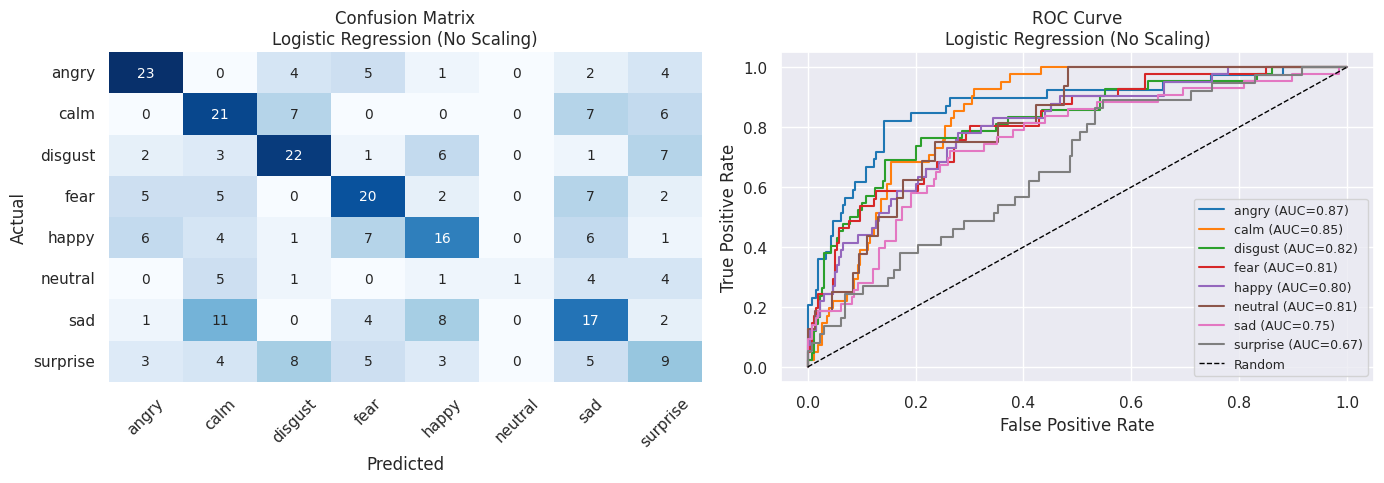


Training Random Forest (No Scaling)...


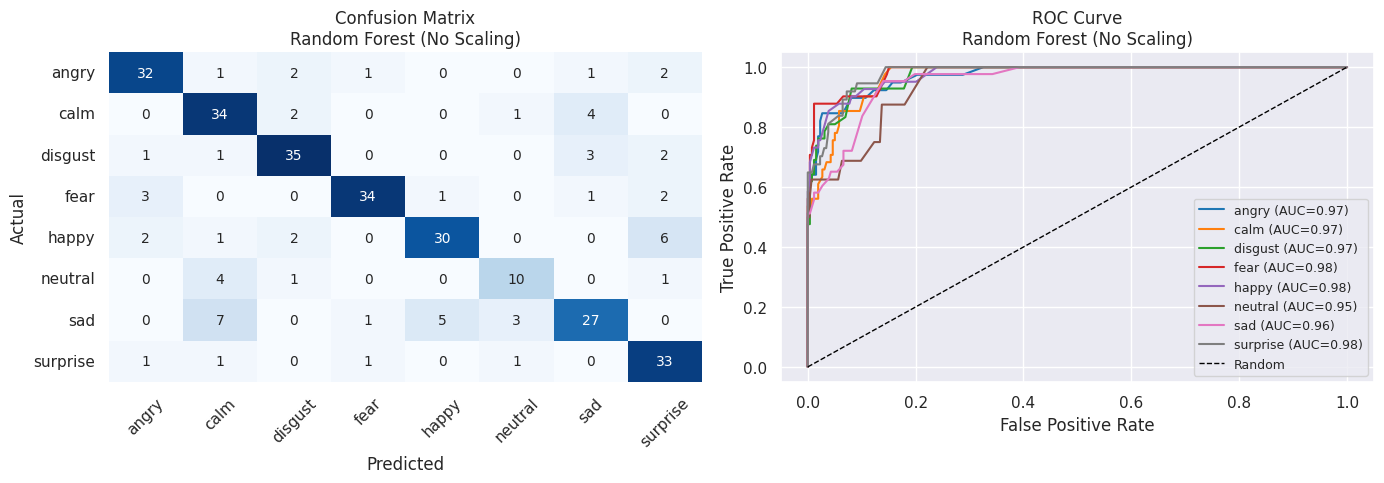


Training Extra Trees (No Scaling)...


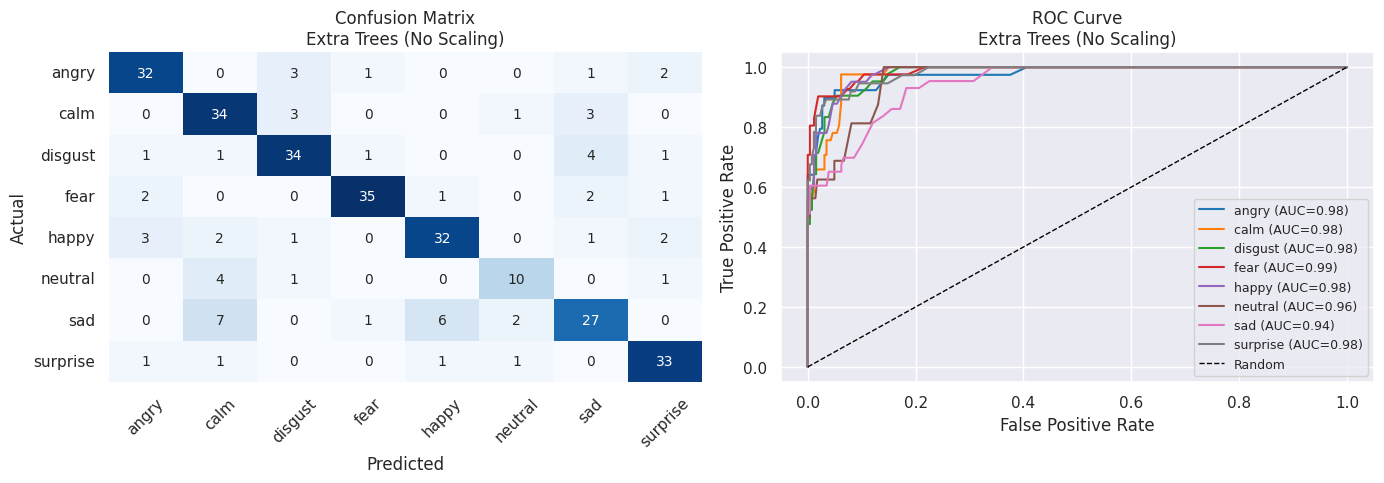


Training Gradient Boosting (No Scaling)...


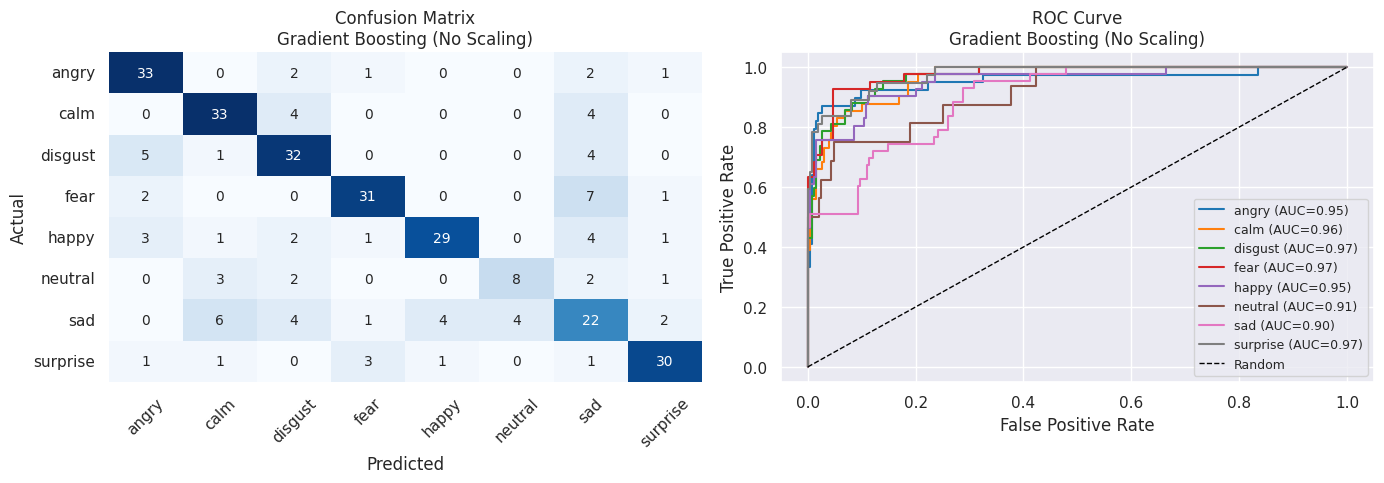


Training XGBoost (No Scaling)...


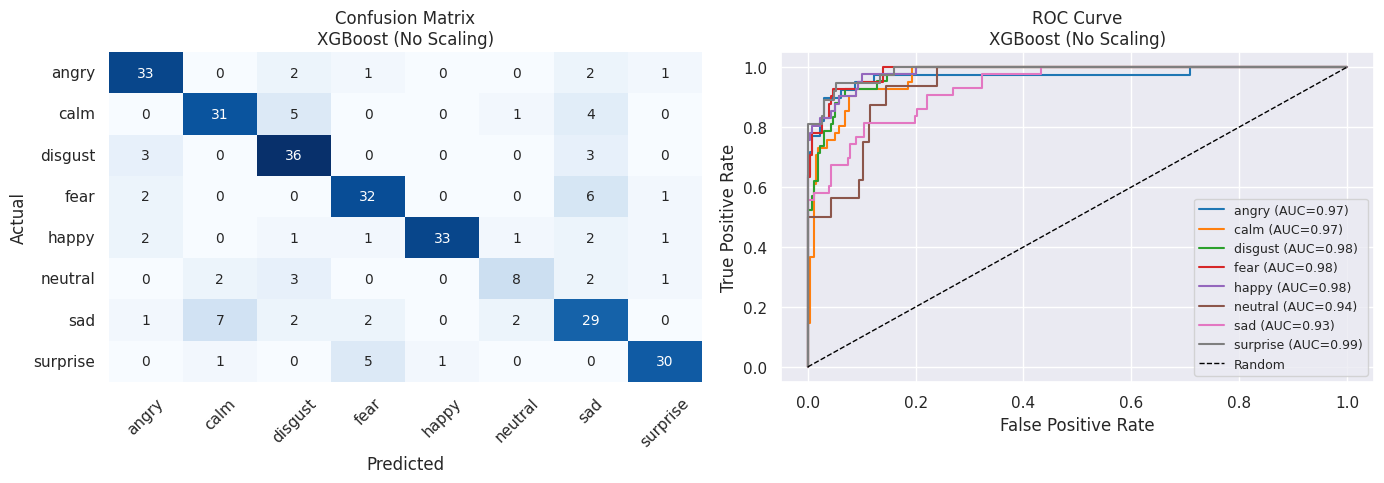


Training SVM (Linear) (No Scaling)...


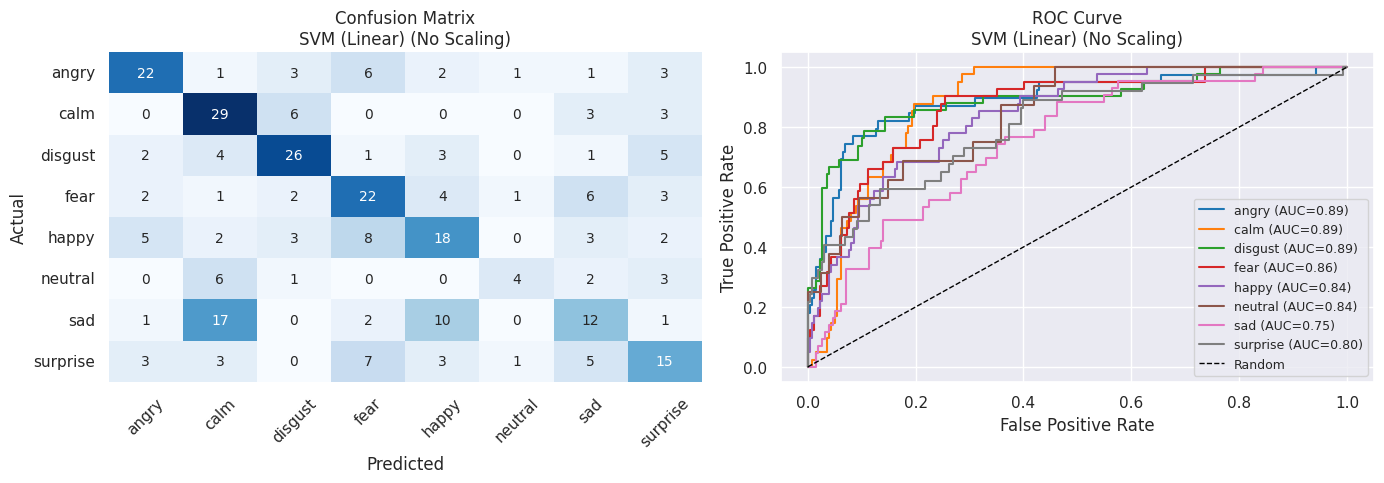


Training SVM (RBF) (No Scaling)...


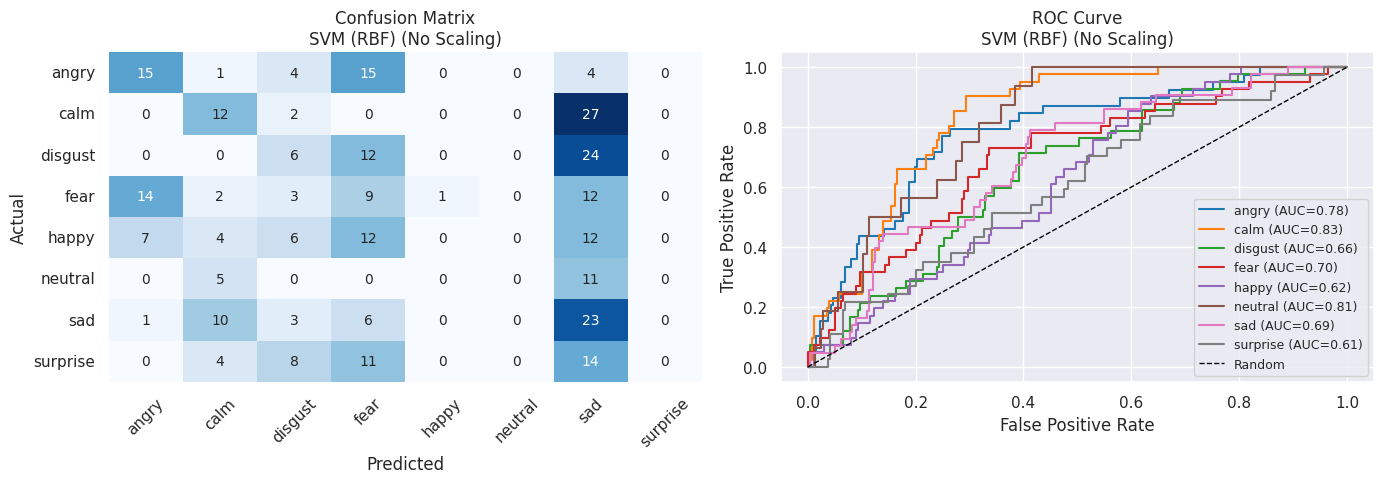


Training KNN (No Scaling)...


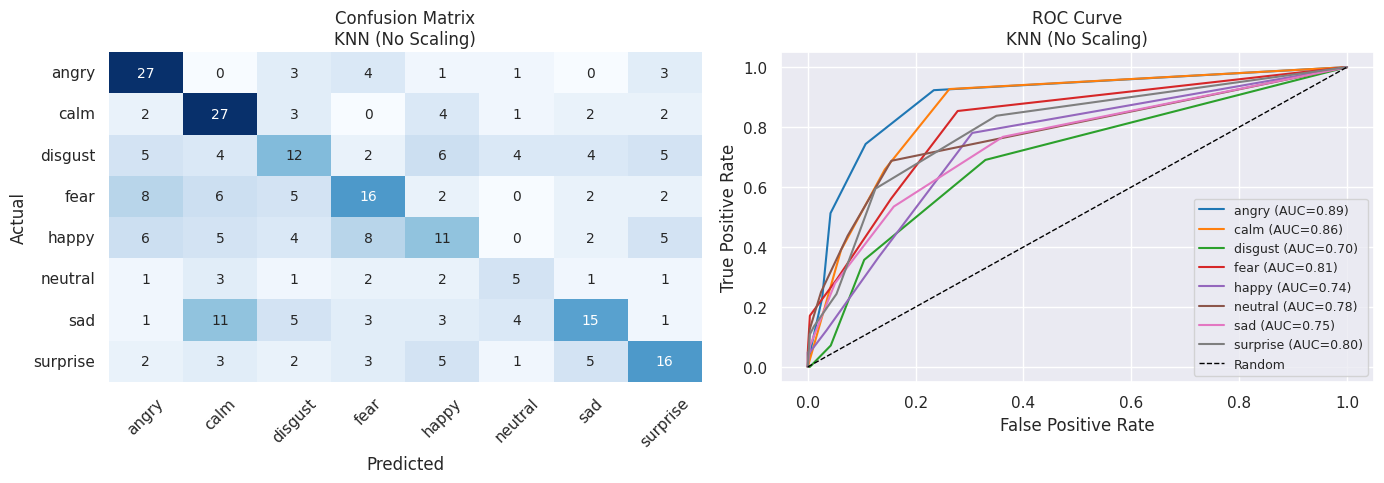


Training MLP (Neural Net) (No Scaling)...


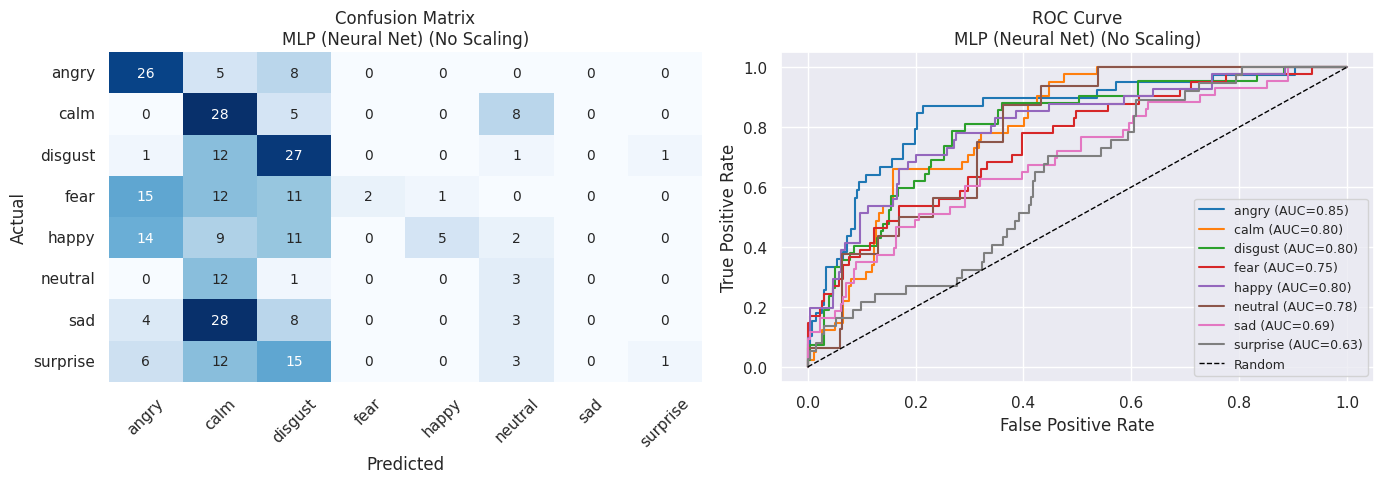


Training AdaBoost (No Scaling)...


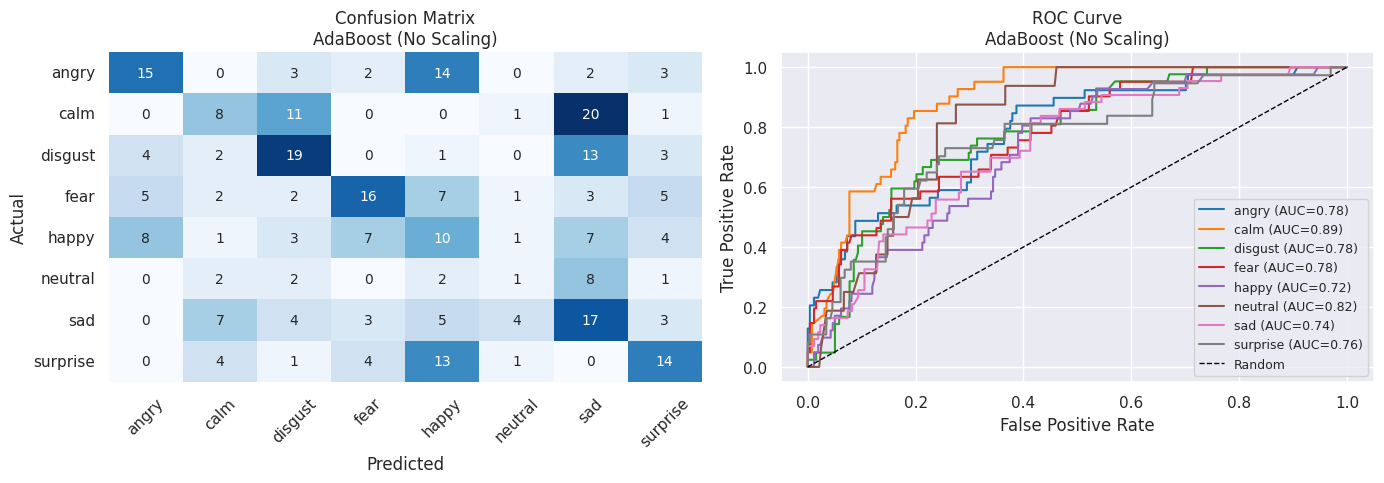


Training Bagging (No Scaling)...


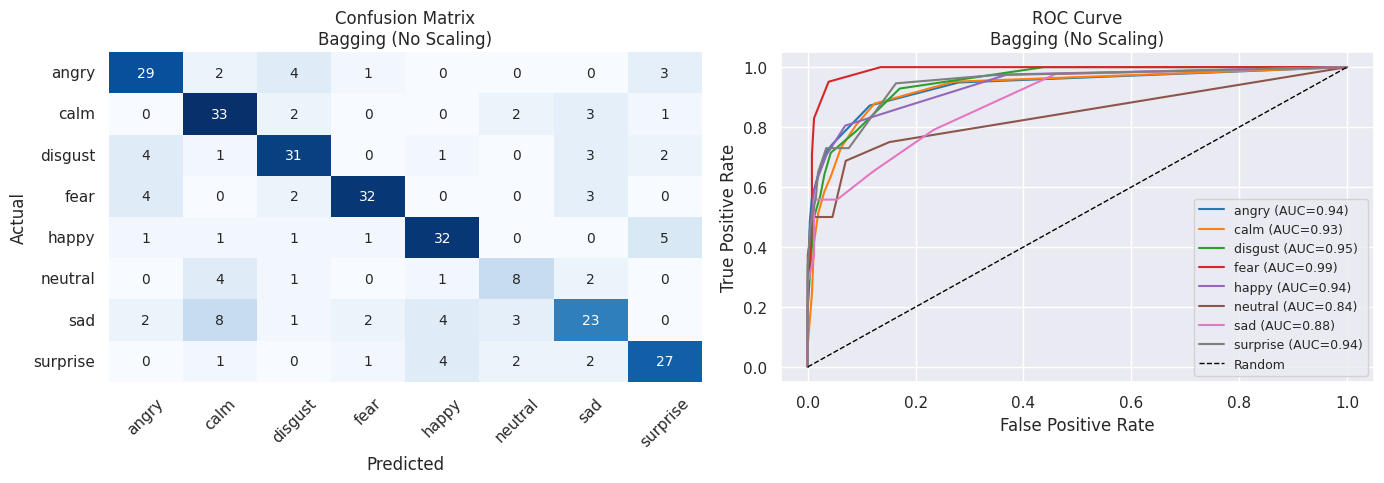


Training Naive Bayes (No Scaling)...


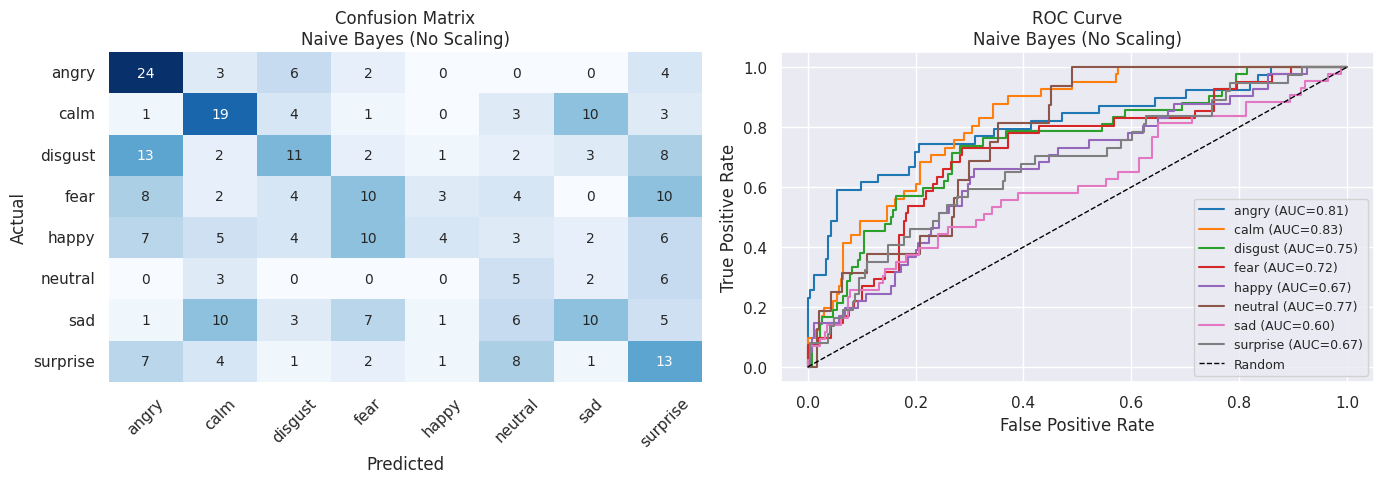


Training QDA (No Scaling)...


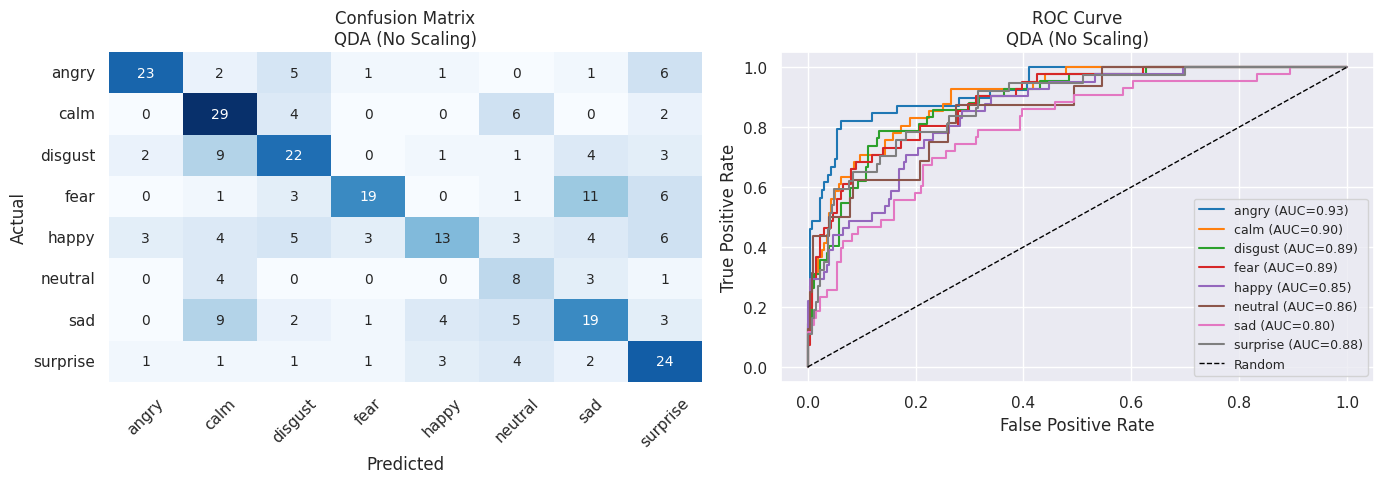


Training LightGBM (No Scaling)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 17
[LightGBM] [Info] Start training from score -2.027482
[LightGBM] [Info] Start training from score -1.978089
[LightGBM] [Info] Start training from score -1.960178
[LightGBM] [Info] Start training from score -2.002481
[LightGBM] [Info] Start training from score -1.996327
[LightGBM] [Info] Start training from score -2.962942
[LightGBM] [Info] Start training from score -1.931022
[LightGBM] [Info] Start training from score -2.106470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

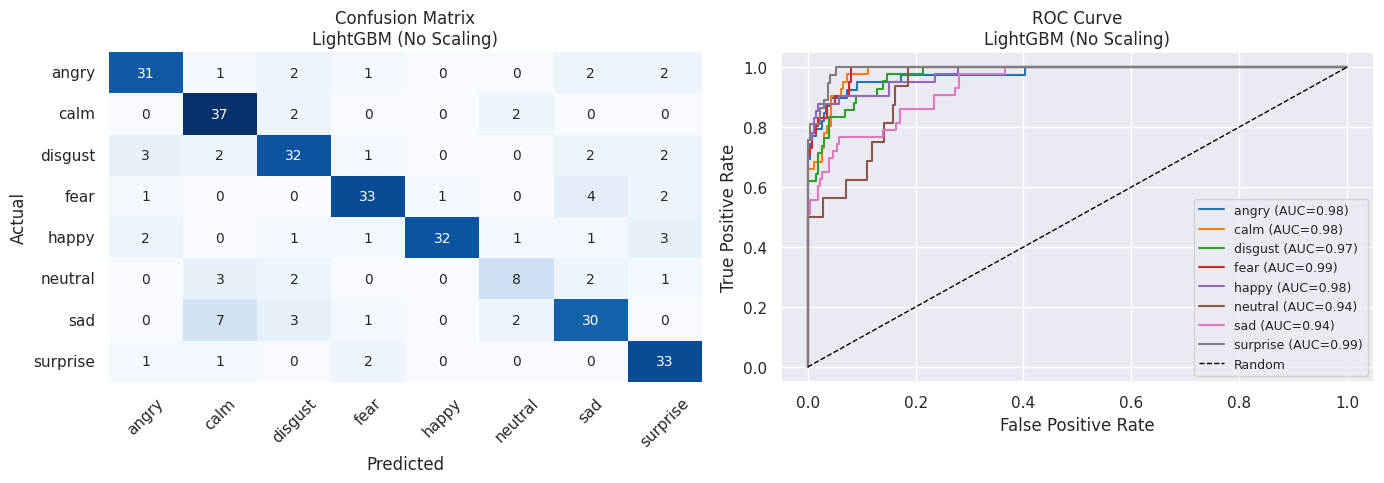

In [50]:
results_no_scaling = train_evaluate_and_plot(X_train, X_test, y_train, y_test, label_suffix=" (No Scaling)")

## Modelling with ***StandardScaler***

### Split Train and Test Data with ***StandardScaler***

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [52]:
X_train_scaled.shape

(1200, 17)

In [53]:
X_test_scaled.shape

(300, 17)

In [54]:
y_train_scaled.shape

(1200,)

In [55]:
y_test_scaled.shape

(300,)

### Train models and plot results with ***StandardScaler***


Training Logistic Regression (Scaled)...


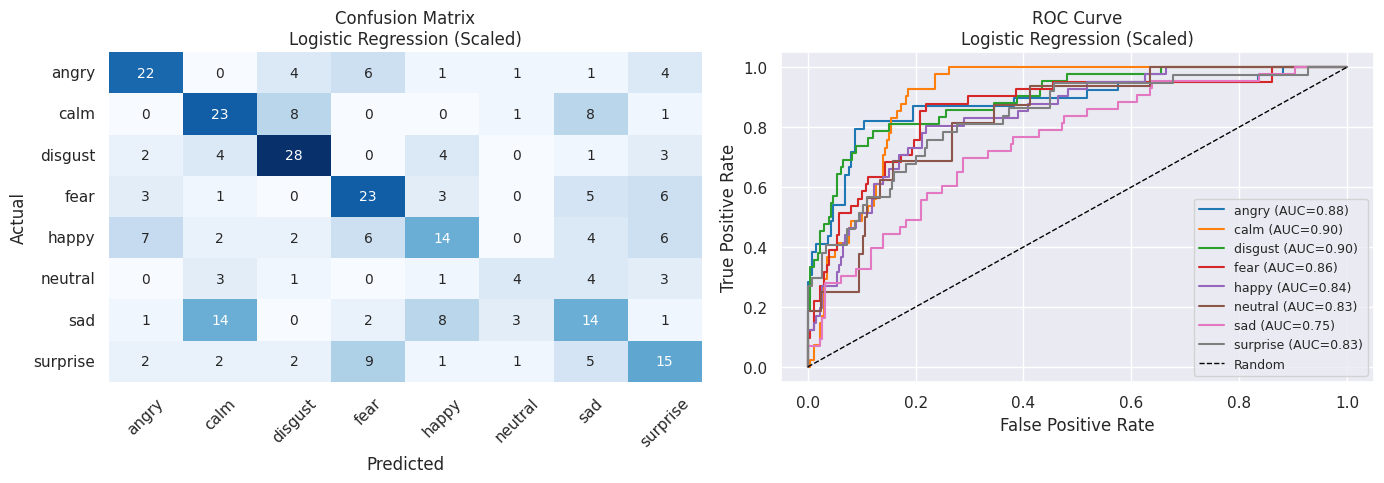


Training Random Forest (Scaled)...


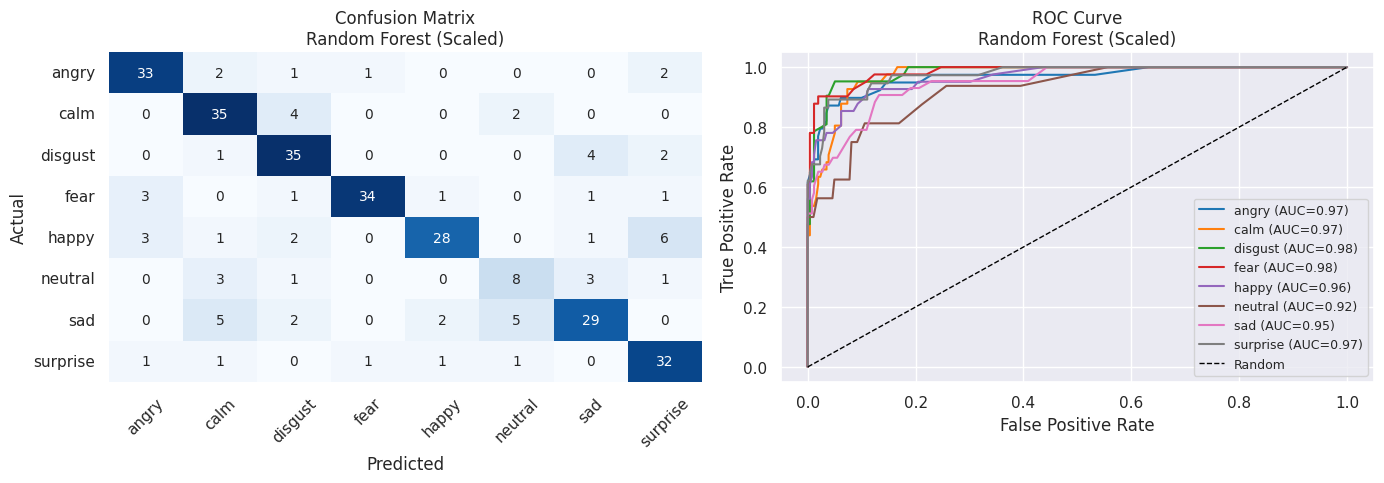


Training Extra Trees (Scaled)...


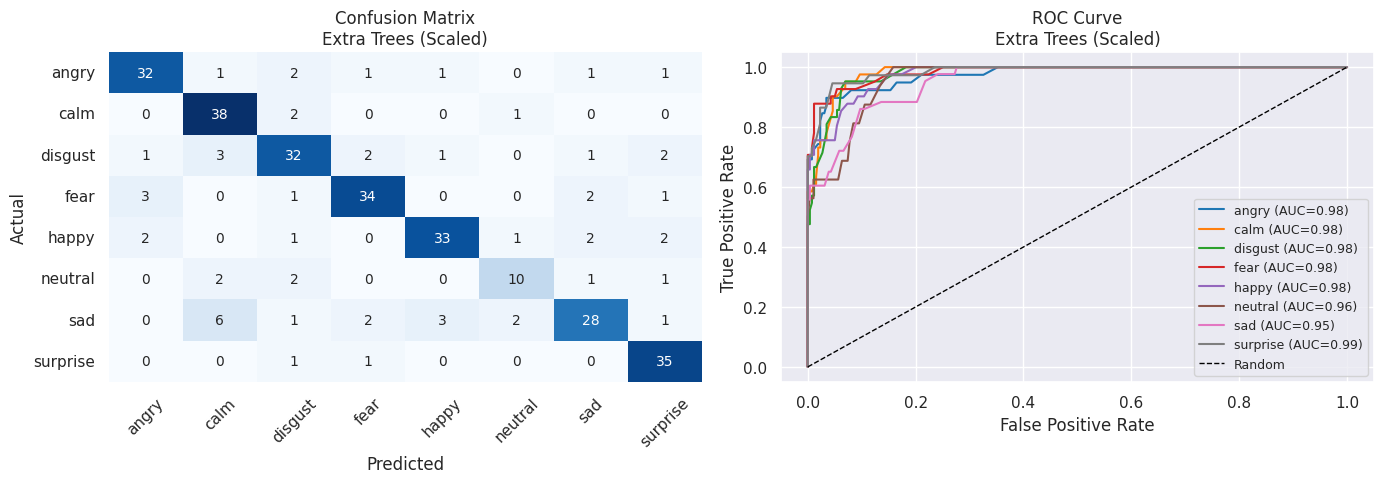


Training Gradient Boosting (Scaled)...


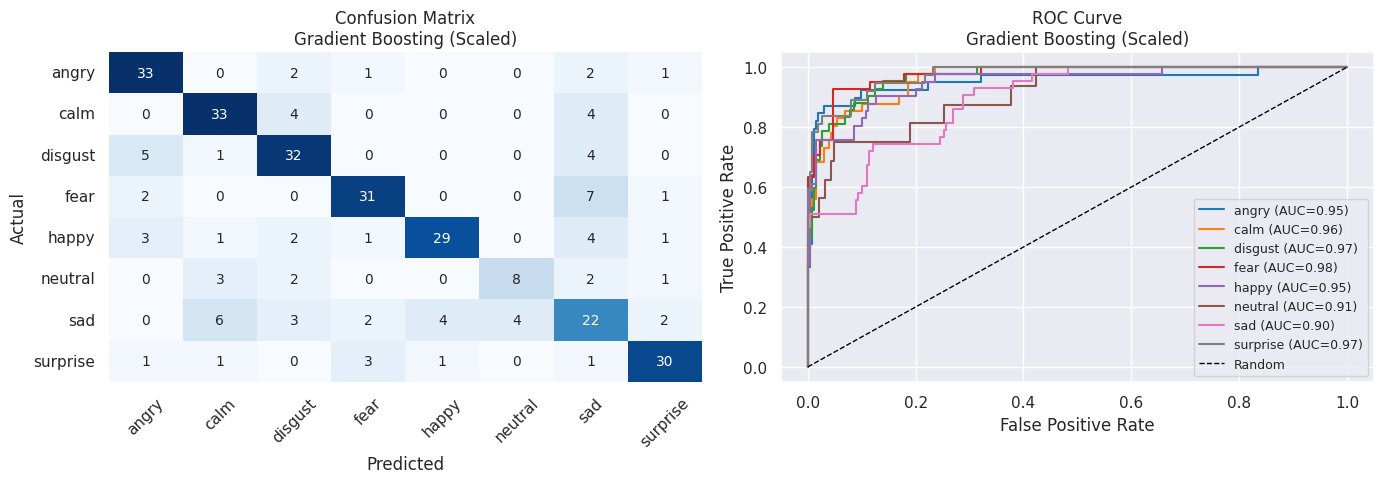


Training XGBoost (Scaled)...


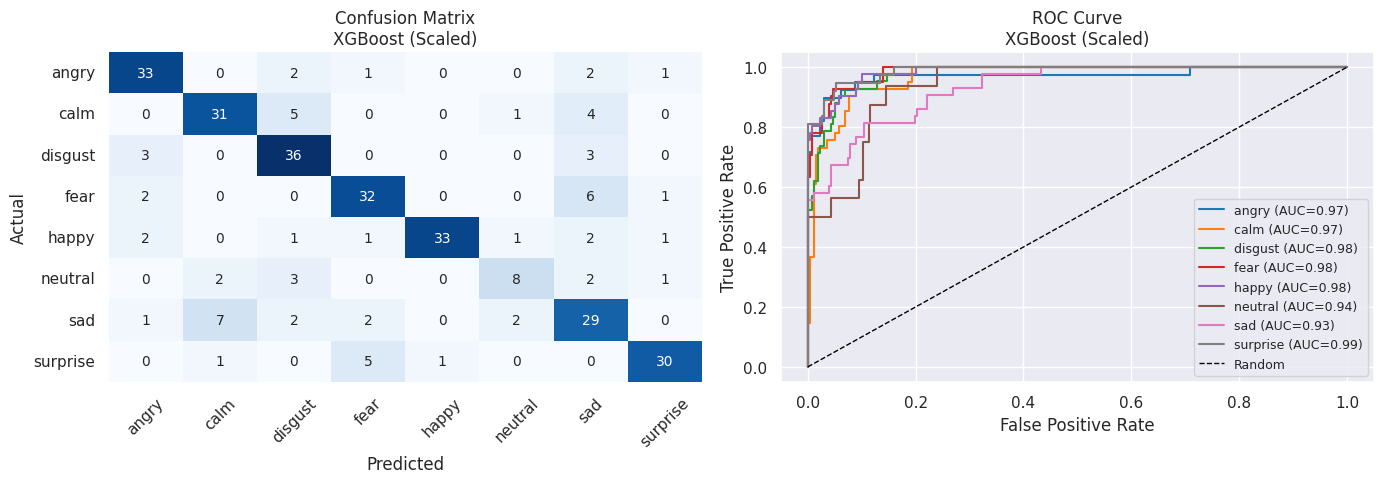


Training SVM (Linear) (Scaled)...


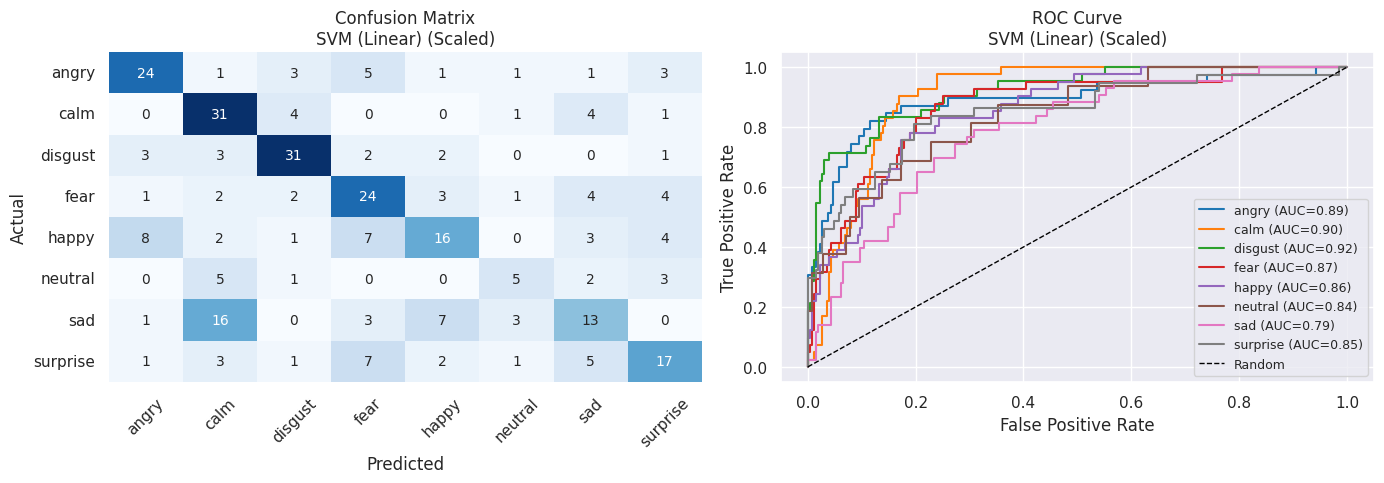


Training SVM (RBF) (Scaled)...


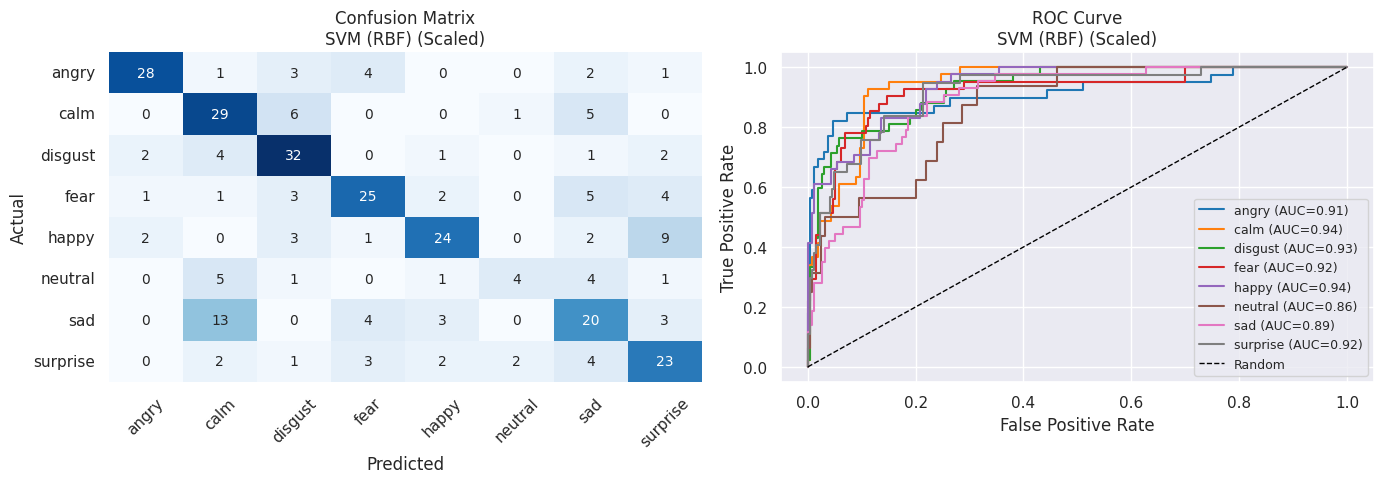


Training KNN (Scaled)...


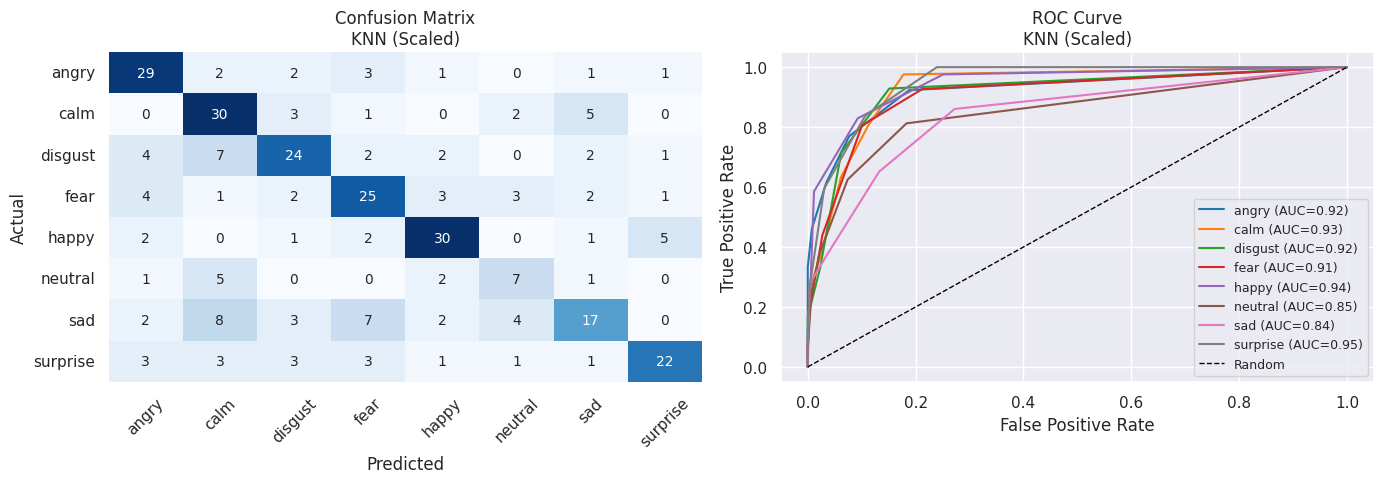


Training MLP (Neural Net) (Scaled)...


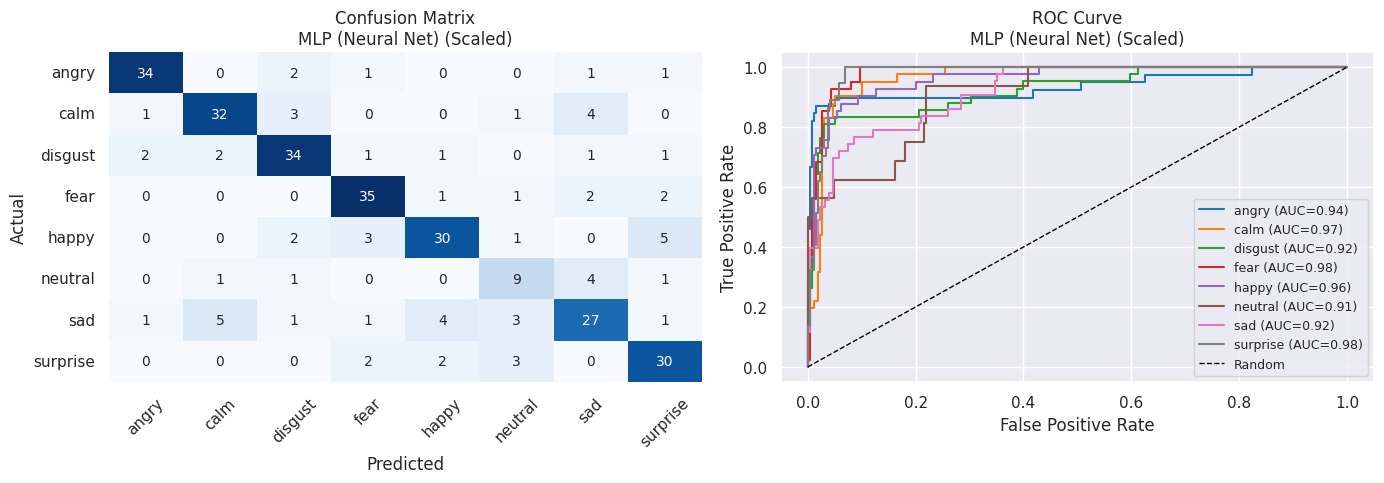


Training AdaBoost (Scaled)...


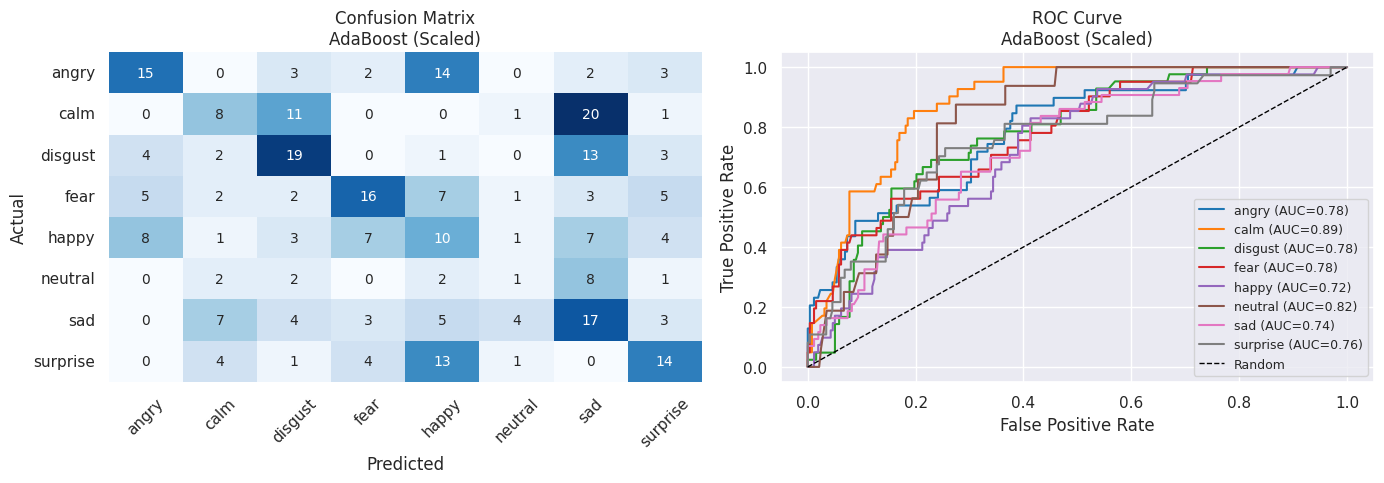


Training Bagging (Scaled)...


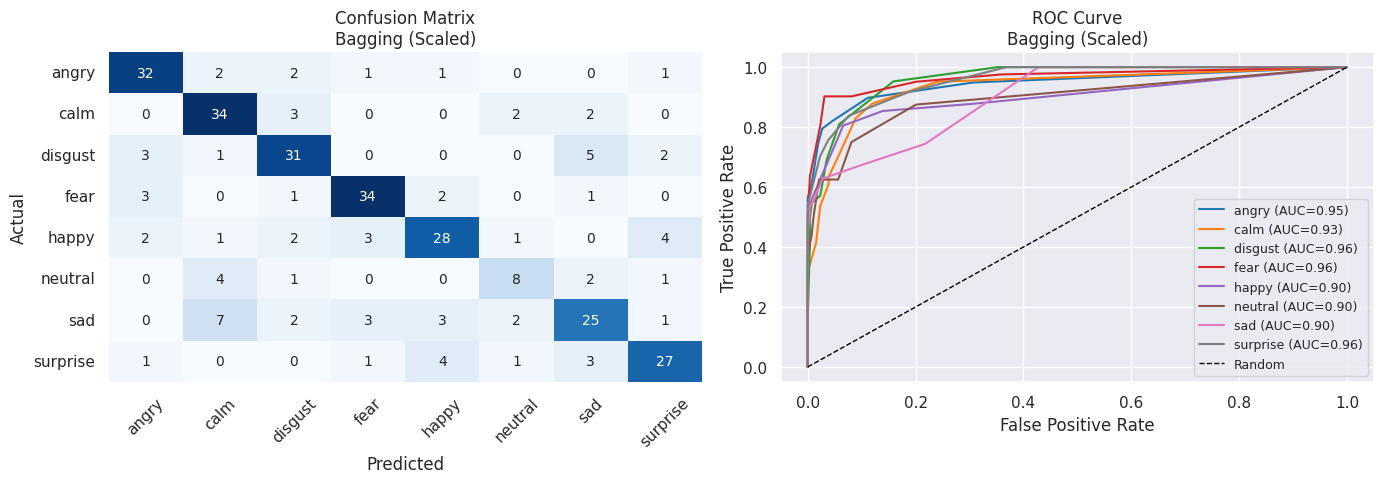


Training Naive Bayes (Scaled)...


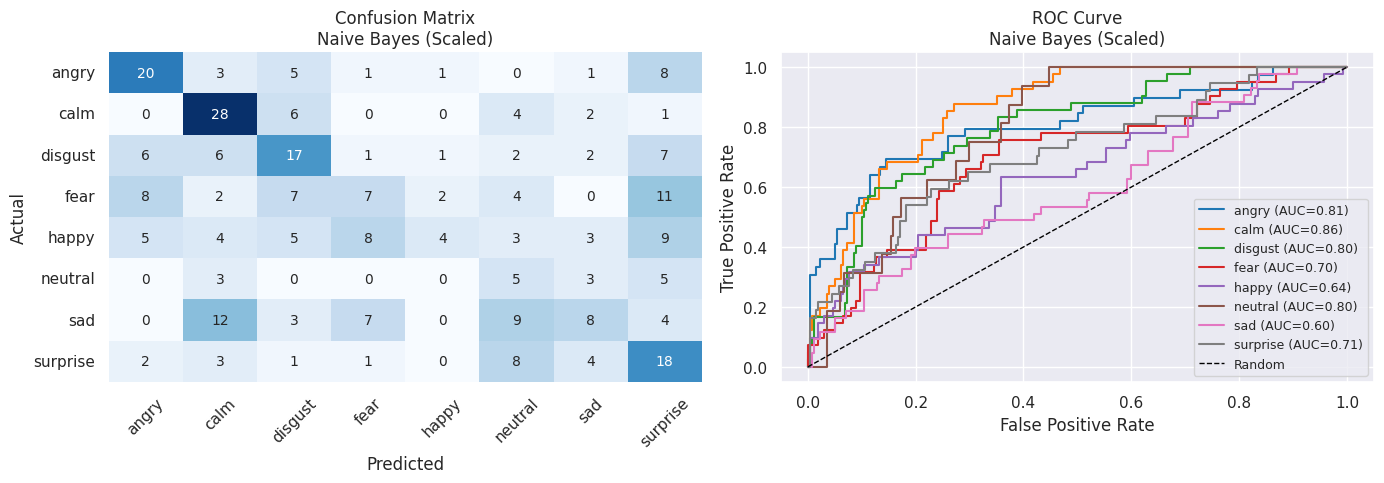


Training QDA (Scaled)...


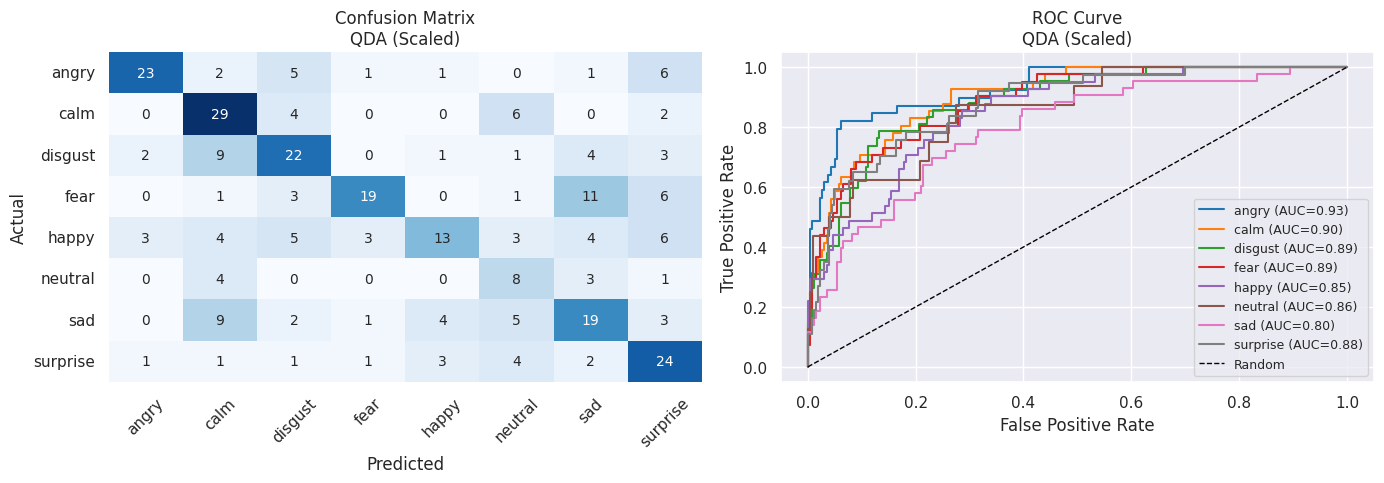


Training LightGBM (Scaled)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 17
[LightGBM] [Info] Start training from score -2.027482
[LightGBM] [Info] Start training from score -1.978089
[LightGBM] [Info] Start training from score -1.960178
[LightGBM] [Info] Start training from score -2.002481
[LightGBM] [Info] Start training from score -1.996327
[LightGBM] [Info] Start training from score -2.962942
[LightGBM] [Info] Start training from score -1.931022
[LightGBM] [Info] Start training from score -2.106470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

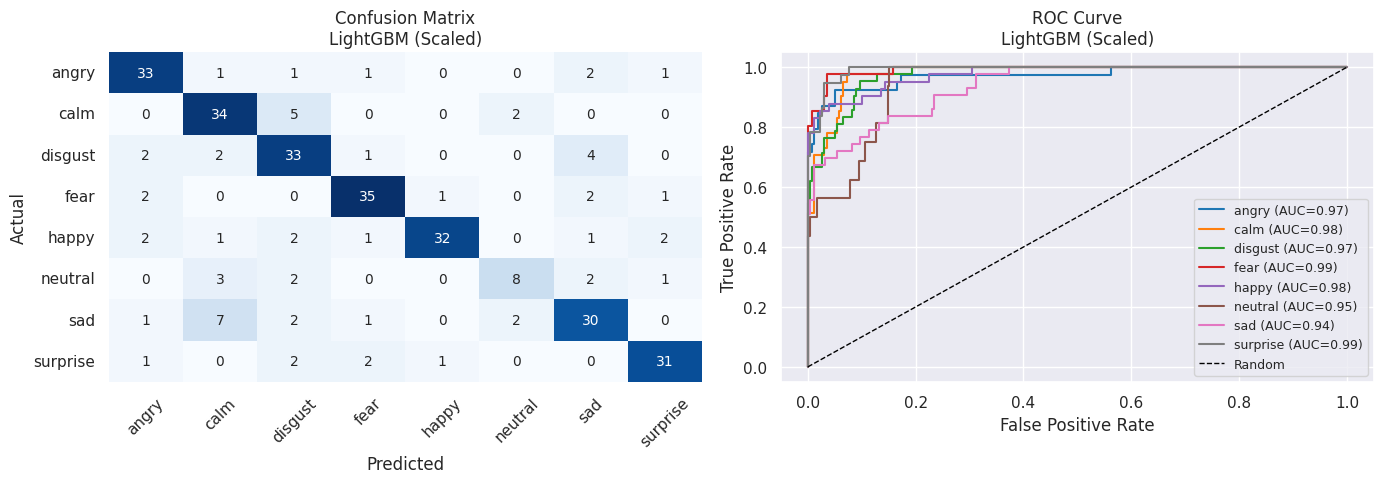

In [56]:
results_scaled = train_evaluate_and_plot(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, label_suffix=" (Scaled)")

# Visualization of combined results (without ***StandardScaler*** and with ***StandardScaler***)

In [91]:
combined_ml_model_results = pd.concat([results_no_scaling, results_scaled])

In [92]:
# def plot_model_comparison_grouped(df, metrics=["Accuracy", "Loss", "Precision", "Recall", "F1 Score"]):
#     unique_models = df['Model'].str.replace(" (Scaled)", "", regex=False).unique()

#     metric_colors = {
#         "Accuracy": "#1f77b4",
#         "Loss": "#ff7f0e",
#         "Precision": "#2ca02c",
#         "Recall": "#d62728",
#         "F1 Score": "#9467bd"
#     }

#     for base_model in unique_models:
#         # Explicitly select unscaled and scaled rows
#         model_unscaled = df[df["Model"] == base_model]
#         model_scaled = df[df["Model"] == f"{base_model} (Scaled)"]
#         model_df = df[df['Model'].str.startswith(base_model)]

#         # Prepare long-form data
#         plot_data = []
#         for _, row in model_df.iterrows():
#             scaler_status = "With Scaler" if "Scaled" in row['Model'] else "Without Scaler"
#             for metric in metrics:
#                 plot_data.append({
#                     "Metric": metric,
#                     "Value": row[metric],
#                     "Scaler_Set": f"{scaler_status} - {row['Set']}"
#                 })

#         plot_df = pd.DataFrame(plot_data)

#         # Plot setup
#         plt.figure(figsize=(12, 6))
#         barplot = sns.barplot(
#             data=plot_df,
#             x="Metric",
#             y="Value",
#             hue="Scaler_Set",
#             palette=[metric_colors[m] for m in plot_df["Metric"].unique()],
#             dodge=True
#         )

#         # Annotate bar values
#         for container in barplot.containers:
#             barplot.bar_label(container, fmt='%.0f%%', labels=[f"{v.get_height()*100:.0f}%" for v in container], padding=3, fontsize=9)

#         # Decorations
#         plt.title(f"All Metrics - {base_model}", fontsize=14)
#         plt.ylim(0, 1.05)
#         plt.ylabel("Score")
#         plt.xlabel("Metric")
#         plt.grid(True, linestyle='--', alpha=0.5)
#         plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
#         plt.tight_layout()
#         plt.show()

In [93]:
def plot_model_comparisons(df, metrics=["Accuracy", "Loss", "Precision", "Recall", "F1 Score"]):
    # Extract base model names
    df['Base_Model'] = df['Model'].str.replace(" \(Scaled\)", "", regex=True)
    df['Scaler'] = df['Model'].apply(lambda x: "With Scaler" if "Scaled" in x else "Without Scaler")

    # Ensure only models with both scaled and unscaled data are considered
    valid_models = df['Base_Model'].value_counts()
    valid_models = valid_models[valid_models == 4].index  # 2 sets (Train/Test) × 2 scalers
    df = df[df['Base_Model'].isin(valid_models)]

    # Metric colors (distinct colors for each metric)
    metric_colors = {
        "Accuracy": "#1f77b4",
        "Loss": "#ff7f0e",
        "Precision": "#2ca02c",
        "Recall": "#d62728",
        "F1 Score": "#9467bd"
    }

    # Plot for each model
    for model in valid_models:
        model_df = df[df['Base_Model'] == model]

        # Convert to long-form for seaborn
        records = []
        for _, row in model_df.iterrows():
            for metric in metrics:
                records.append({
                    "Metric": metric,
                    "Value": row[metric],
                    "Group": f"{row['Scaler']} - {row['Set']}"
                })

        plot_df = pd.DataFrame(records)

        # Plotting
        plt.figure(figsize=(12, 6))
        bar = sns.barplot(
            data=plot_df,
            x="Metric",
            y="Value",
            hue="Group",
            palette=[metric_colors[m] for m in metrics],
            dodge=True
        )

        # Annotate values as percentages
        for container in bar.containers:
            bar.bar_label(container, labels=[f"{h.get_height()*100:.0f}%" for h in container], padding=3, fontsize=9)

        # Final touches
        plt.title(f"Performance Comparison - {model}", fontsize=14)
        plt.ylim(0, 1.05)
        plt.ylabel("Score")
        plt.xlabel("Metric")
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.legend(title=None, bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


In [94]:
plot_model_comparisons(combined_ml_model_results)

In [95]:
combined_ml_model_results

Model    Set  Accuracy      Loss  Precision  \
0   Logistic Regression (No Scaling)  Train  0.455000  0.545000   0.447570   
1   Logistic Regression (No Scaling)   Test  0.430000  0.570000   0.459483   
2         Random Forest (No Scaling)  Train  1.000000  0.000000   1.000000   
3         Random Forest (No Scaling)   Test  0.783333  0.216667   0.789172   
4           Extra Trees (No Scaling)  Train  1.000000  0.000000   1.000000   
5           Extra Trees (No Scaling)   Test  0.790000  0.210000   0.791728   
6     Gradient Boosting (No Scaling)  Train  0.998333  0.001667   0.998343   
7     Gradient Boosting (No Scaling)   Test  0.726667  0.273333   0.733071   
8               XGBoost (No Scaling)  Train  1.000000  0.000000   1.000000   
9               XGBoost (No Scaling)   Test  0.773333  0.226667   0.781115   
10         SVM (Linear) (No Scaling)  Train  0.567500  0.432500   0.566168   
11         SVM (Linear) (No Scaling)   Test  0.493333  0.506667   0.495722   
12            SVM (RBF) (No Scaling)  Train  0.265833  0.734167   0.245493   
13            SVM (RBF) (No Scaling)   Test  0.216667  0.783333   0.166992   
14                  KNN (No Scaling)  Train  0.618333  0.381667   0.619739   
15                  KNN (No Scaling)   Test  0.430000  0.570000   0.422204   
16     MLP (Neural Net) (No Scaling)  Train  0.299167  0.700833   0.453165   
17     MLP (Neural Net) (No Scaling)   Test  0.306667  0.693333   0.447817   
18             AdaBoost (No Scaling)  Train  0.397500  0.602500   0.419040   
19             AdaBoost (No Scaling)   Test  0.333333  0.666667   0.348235   
20              Bagging (No Scaling)  Train  0.992500  0.007500   0.992573   
21              Bagging (No Scaling)   Test  0.716667  0.283333   0.717759   
22          Naive Bayes (No Scaling)  Train  0.373333  0.626667   0.393729   
23          Naive Bayes (No Scaling)   Test  0.320000  0.680000   0.335718   
24                  QDA (No Scaling)  Train  0.643333  0.356667   0.672649   
25                  QDA (No Scaling)   Test  0.523333  0.476667   0.563407   
26             LightGBM (No Scaling)  Train  1.000000  0.000000   1.000000   
27             LightGBM (No Scaling)   Test  0.786667  0.213333   0.792386   
0       Logistic Regression (Scaled)  Train  0.555000  0.445000   0.552763   
1       Logistic Regression (Scaled)   Test  0.476667  0.523333   0.473230   
2             Random Forest (Scaled)  Train  1.000000  0.000000   1.000000   
3             Random Forest (Scaled)   Test  0.780000  0.220000   0.787832   
4               Extra Trees (Scaled)  Train  1.000000  0.000000   1.000000   
5               Extra Trees (Scaled)   Test  0.806667  0.193333   0.808007   
6         Gradient Boosting (Scaled)  Train  0.998333  0.001667   0.998343   
7         Gradient Boosting (Scaled)   Test  0.726667  0.273333   0.732222   
8                   XGBoost (Scaled)  Train  1.000000  0.000000   1.000000   
9                   XGBoost (Scaled)   Test  0.773333  0.226667   0.781115   
10             SVM (Linear) (Scaled)  Train  0.590000  0.410000   0.586864   
11             SVM (Linear) (Scaled)   Test  0.536667  0.463333   0.533142   
12                SVM (RBF) (Scaled)  Train  0.746667  0.253333   0.748806   
13                SVM (RBF) (Scaled)   Test  0.616667  0.383333   0.628640   
14                      KNN (Scaled)  Train  0.798333  0.201667   0.800827   
15                      KNN (Scaled)   Test  0.613333  0.386667   0.618498   
16         MLP (Neural Net) (Scaled)  Train  0.980833  0.019167   0.980816   
17         MLP (Neural Net) (Scaled)   Test  0.770000  0.230000   0.771623   
18                 AdaBoost (Scaled)  Train  0.397500  0.602500   0.419040   
19                 AdaBoost (Scaled)   Test  0.333333  0.666667   0.348235   
20                  Bagging (Scaled)  Train  0.994167  0.005833   0.994222   
21                  Bagging (Scaled)   Test  0.730000  0.270000   0.728238   
22              Naive Bayes (Scaled)  Train  0.395833

# Train the same with Basic Deep Learning Models

In [105]:
y_train_nn = to_categorical(y_train_scaled)
y_test_nn = to_categorical(y_test_scaled)

histories = []

## Shallow network with two dense layers and dropout

In [106]:
model1 = Sequential()
model1.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model1.add(Dropout(0.3))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(y_train_nn.shape[1], activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(X_train_scaled, y_train_nn,
                      validation_data=(X_test_scaled, y_test_nn),
                      epochs=50, batch_size=16, verbose=1)

histories.append(('BasicNN_Dropout', history1))

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2088 - loss: 2.0409 - val_accuracy: 0.3433 - val_loss: 1.8102
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3470 - loss: 1.7582 - val_accuracy: 0.4333 - val_loss: 1.6497
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3741 - loss: 1.6454 - val_accuracy: 0.4633 - val_loss: 1.5239
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4048 - loss: 1.5410 - val_accuracy: 0.5000 - val_loss: 1.4401
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4735 - loss: 1.3971 - val_accuracy: 0.5267 - val_loss: 1.3739
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4745 - loss: 1.4366 - val_accuracy: 0.5567 - val_loss: 1.3161
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5052 - loss: 1.3098 - val_accuracy: 0.5600 - val_loss: 1.2902
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5491 - loss: 1.2397 - val_accuracy: 0.5633 - val_loss:

## Deeper network with 3 hidden layers and more dropout

In [107]:
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model2.add(Dropout(0.4))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(y_train_nn.shape[1], activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(X_train_scaled, y_train_nn,
                      validation_data=(X_test_scaled, y_test_nn),
                      epochs=50, batch_size=16, verbose=1)

histories.append(('DeepNN_Regularized', history2))

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2280 - loss: 2.0302 - val_accuracy: 0.3867 - val_loss: 1.7634
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3407 - loss: 1.7406 - val_accuracy: 0.4567 - val_loss: 1.5498
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4238 - loss: 1.5472 - val_accuracy: 0.4933 - val_loss: 1.4394
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4649 - loss: 1.4353 - val_accuracy: 0.4967 - val_loss: 1.3764
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4914 - loss: 1.3580 - val_accuracy: 0.5367 - val_loss: 1.3152
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5207 - loss: 1.2957 - val_accuracy: 0.5533 - val_loss: 1.2674
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5322 - loss: 1.2590 - val_accuracy: 0.5800 - val_loss: 1.2084
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5253 - loss: 1.2476 - val_accuracy: 0.5700 - val_loss:

## Batch normalization + activation after each dense layer + dropout

In [108]:
model3 = Sequential()
model3.add(Dense(256, input_shape=(X_train_scaled.shape[1],)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.3))

model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.3))

model3.add(Dense(64))
model3.add(Activation('relu'))
model3.add(Dense(y_train_nn.shape[1], activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(X_train_scaled, y_train_nn,
                      validation_data=(X_test_scaled, y_test_nn),
                      epochs=50, batch_size=16, verbose=1)

histories.append(('BN_Activated_DeepNN', history3))

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2037 - loss: 2.0521 - val_accuracy: 0.4533 - val_loss: 1.7582
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3922 - loss: 1.5991 - val_accuracy: 0.5000 - val_loss: 1.5521
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4628 - loss: 1.4221 - val_accuracy: 0.5500 - val_loss: 1.4095
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5033 - loss: 1.3545 - val_accuracy: 0.5567 - val_loss: 1.3106
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4898 - loss: 1.3820 - val_accuracy: 0.5867 - val_loss: 1.2459
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5265 - loss: 1.2632 - val_accuracy: 0.6167 - val_loss: 1.1800
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5611 - loss: 1.2304 - val_accuracy: 0.6067 - val_loss: 1.1658
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5489 - loss: 1.1907 - val_accuracy: 0.6367 - val_loss:

# Visualization of Deep Learning Model Results

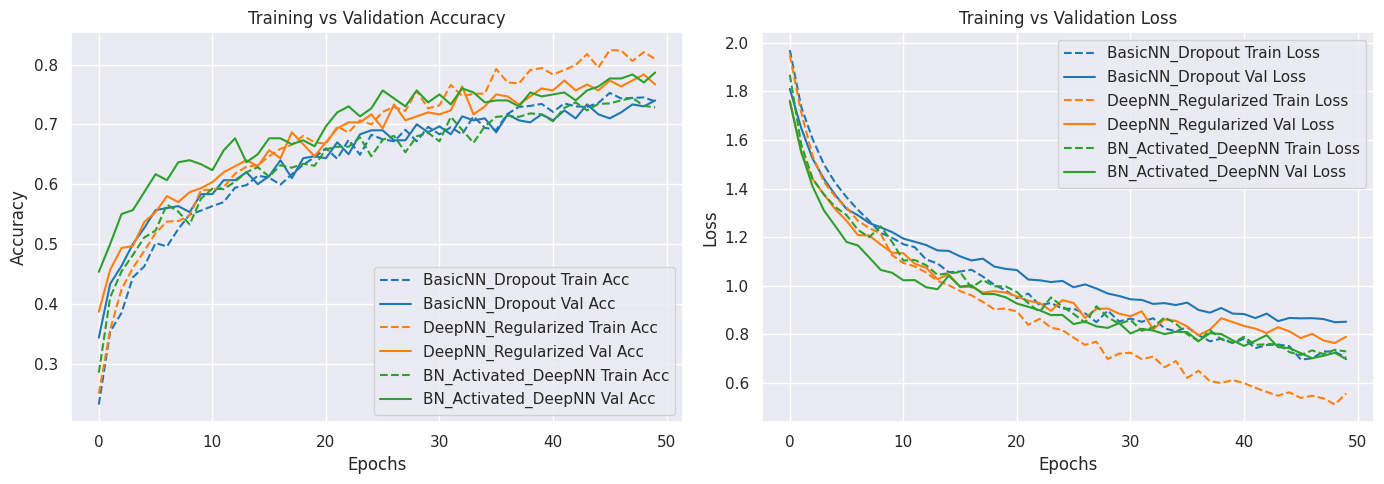

In [111]:
colors = itertools.cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
for name, hist in histories:
    color = next(colors)
    plt.plot(hist.history['accuracy'], linestyle='--', label=f'{name} Train Acc', color=color)
    plt.plot(hist.history['val_accuracy'], linestyle='-', label=f'{name} Val Acc', color=color)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Reset color cycle for Loss Plot
colors = itertools.cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])

# Loss Plot
plt.subplot(1, 2, 2)
for name, hist in histories:
    color = next(colors)
    plt.plot(hist.history['loss'], linestyle='--', label=f'{name} Train Loss', color=color)
    plt.plot(hist.history['val_loss'], linestyle='-', label=f'{name} Val Loss', color=color)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()